# Project 3 - Article Parsing Toolset

## Team 3 Members

- Matthew Dunbar
- Jeffrei Cher
- Basil James

## Project Problem

To parse article content and extract various data from the article contents

- _**Article Classification into a set of pre-defined categories**_
  (a prediction model)

For Sports Articles:
- _**to identify the sport, and extract game/match scores if present**_
- _(to provide stats summaries if present?)_

## Learning Goal

Develop experience:

- Building and deploying models to leverage in real world applications
- Leveraging custom training of LLMs to provide article analysis.
- Using a tool-based (extensible toolbox) approach to provide multiple analytics features


## Dataset

- https://www.kaggle.com/datasets/fabiochiusano/medium-articles  
[size: 190k+, categories: multiple tags per article, large set, Includes titles, full articles, and URLs]

### Retrieve dataset

In [4]:
! kaggle datasets download -d fabiochiusano/medium-articles -p ./data --unzip

Dataset URL: https://www.kaggle.com/datasets/fabiochiusano/medium-articles
License(s): CC0-1.0
 97%|███████████████████████████████████████▉ | 359M/369M [00:03<00:00, 145MB/s]
100%|█████████████████████████████████████████| 369M/369M [00:03<00:00, 116MB/s]


### Local file

In [6]:
!ls -l ./data/

total 1017916
-rw-r--r-- 1 jupyter jupyter 1042340506 Apr  9 16:11 medium_articles.csv


### Fulfill basic Dataframe dependencies

In [9]:
import os

import pandas as pd
from google.cloud import bigquery

import subprocess
import warnings

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings("ignore")

import json
from pprint import pprint
import markdown
# import tensorflow as tf

# print(tf.version.VERSION)

### Load dataframe

In [9]:
# Load dataset (change filename accordingly)
df = pd.read_csv('./data/medium_articles.csv')

# Display first few rows
df.head()

,title,text,url,authors,timestamp,tags
0,Mental Note Vol. 24,Photo by Josh Riemer on Unsplash\n\nMerry Chri...,https://medium.com/invisible-illness/mental-no...,['Ryan Fan'],2020-12-26 03:38:10.479000+00:00,"['Mental Health', 'Health', 'Psychology', 'Sci..."
1,Your Brain On Coronavirus,Your Brain On Coronavirus\n\nA guide to the cu...,https://medium.com/age-of-awareness/how-the-pa...,['Simon Spichak'],2020-09-23 22:10:17.126000+00:00,"['Mental Health', 'Coronavirus', 'Science', 'P..."
2,Mind Your Nose,Mind Your Nose\n\nHow smell training can chang...,https://medium.com/neodotlife/mind-your-nose-f...,[],2020-10-10 20:17:37.132000+00:00,"['Biotechnology', 'Neuroscience', 'Brain', 'We..."
3,The 4 Purposes of Dreams,Passionate about the synergy between science a...,https://medium.com/science-for-real/the-4-purp...,['Eshan Samaranayake'],2020-12-21 16:05:19.524000+00:00,"['Health', 'Neuroscience', 'Mental Health', 'P..."
4,Surviving a Rod Through the Head,"You’ve heard of him, haven’t you? Phineas Gage...",https://medium.com/live-your-life-on-purpose/s...,['Rishav Sinha'],2020-02-26 00:01:01.576000+00:00,"['Brain', 'Health', 'Development', 'Psychology..."


### Parse DataFrame to remove unwanted columns

In [10]:
# parse the CSV data
CSV_COLUMNS = [
    "title",
    "text",
    "url",
    "authors",
    "timestamp",
    "tags",
]
LABEL_COLUMN = "text"
DEFAULTS = [["na"], ["na"], ["na"], ["na"], ["na"], ["na"]]
UNWANTED_COLS = ["title", "url", "authors", "timestamp"]

DESIRED_COLUMNS = [col for col in CSV_COLUMNS if col not in UNWANTED_COLS]
df = df[DESIRED_COLUMNS]

# Show full column width and prevent truncation
pd.set_option("display.max_colwidth", None)  # Show full text
pd.set_option("display.expand_frame_repr", False)  # Prevent wrapping

df.head()

text                                                                       tags
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Photo by Josh Riemer on Unsplash\n\nMerry Christmas and Happy Holidays, everyone!\n\nWe just wanted everyone to know how much we appreciate everyone and how thankful we are for all our readers and writers here. We wouldn’t be anywhere without you, so thank you all for bringing informative, vulnerable, and important pieces that destigmatize mental illness and mental health.\n\nWithout further ado, here are ten of our top stories from last week, all of which were curated:\n\n“Just as the capacity to love and inspire is universal so is the capacity to hate and discourage. Irrespective of gender, race, age or religion none of us are exempt from aggressive proclivities. Those who are narcissistically disordered, and accordingly repress deep seated feelings of inferiority with inflated delusions of grandeur and superiority, are more prone to aggression and violence. They infiltrate our interactions in myriad environments from home, work, school and the cyber world. Hence, bullying does not happen in isolation. Although there is a ringleader she looks to her minions to either sanction her cruelty or look the other way.”\n\n“Even though the circumstances that brought me here were sad and challenging, I’m grateful for how this program has changed my life for the better. I can’t help but imagine what life would be like if everyone learned to accept their powerlessness over other people, prioritize their serenity, and take life one step at a time. We’ll never know, but I’d bet the world would be much happier.”\n\n“The prospect of spending a horrible Christmas, locked in on a psychiatric unit, was one of 

### Check formatting within text column

In [69]:
print(df["text"].iloc[4])  # Display only the 'text' column

You’ve heard of him, haven’t you? Phineas Gage. The railroad worker who survived an explosion that involved an iron rod piercing through his left cheek and out of his brain and skull.

Yeah.

I know.

You’re probably wondering “yeah, alright sweet. What about him?” Well, let’s just say that he was a really popular patient for the field of neuroscience (Cherry, par. 1). And what I found the most interesting about this tragic event was the science of his behavior afterward.

For those of you who don’t know much about Phineas Gage, let me fill you in with the help of my research.

Phineas Gage, 25 years old, was a railroad worker in Vermont. One day, at work, he was using an iron rod to handle explosive gun powder. As he was using the iron rod to handle the gun powder, an explosion suddenly occurred. The iron rod then went through his left cheek and brain. Fortunately, he survived and was able to talk and walk after the accident (Cherry, par. 2–3).

Why did people say that Phineas Gage wa

### Parse Data Sets from DataFrame

In [11]:
from sklearn.model_selection import train_test_split

# Split into training and temp (validation + test) set (70% train, 30% temp)
train, temp = train_test_split(df, test_size=0.3, random_state=42)

# Split the temp set into validation and test set (50% validation, 50% test of the 30%)
validate, test = train_test_split(temp, test_size=0.5, random_state=42)

# Print counts of rows in each set
print(f"Training Set Size: {train.shape[0]}")
print(f"Validation Set Size: {validate.shape[0]}")
print(f"Test Set Size: {test.shape[0]}")

Training Set Size: 134657
Validation Set Size: 28855
Test Set Size: 28856


## Solution

### Approach

LLM-based tool(s) with tool-specific training, with tool-specific engineered prompt(s).
Modular. Function-based.  Extensible.


#### Input: content of the article to analyse

(ideally, the contents directly.  alternate consideration might be to provide a URL, but that would require additional python supporting fucntions to pull, then clean up the contents prior to submission)

#### Output: variable per tool/function

### Instantiate an LLM, and set it up to support one or more functions

#### Ensure the required pip underpinnings are installed (required when having to spin up a new workbench instance)

In [16]:
!pip install google-genai
!pip show google-genai

  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
Using cached httpx-0.28.1-py3-none-any.whl (73 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
asl 0.1 requires google-genai==1.2.0, but you have google-genai 1.10.0 which is incompatible.
langchain-google-vertexai 2.0.10 requires httpx<0.28.0,>=0.27.0, but you have httpx 0.28.1 which is incompatible.
Name: google-genai
Version: 1.10.0
Summary: GenAI Python SDK
Home-page: https://github.com/googleapis/python-genai
Author: 
Author-email: Google LLC <googleapis-packages@google.com>
License: Apache-2.0
Location: /opt/conda/lib/python3.10/site-packages
Requires: anyio, google-auth, httpx, pydantic, requests, typing-extensions, websockets
Required-by: asl


#### Instantiate the new LLM

In [39]:
# Instantiate an LLM
from typing import Any, Callable, Optional, Tuple, Union

from google import genai
from google.cloud import bigquery
from google.genai.types import (
    FunctionDeclaration,
    GenerateContentConfig,
    GenerateContentResponse,
    Part,
    Schema,
    Tool,
)
from IPython.display import Markdown

REGION = "us-central1"
PROJECT = !(gcloud config get-value core/project)
PROJECT = PROJECT[0]

MODEL = "gemini-2.0-flash-001"

client = genai.Client(vertexai=True, location="us-central1")

# Define the ChatAgent parent class
class ChatAgent:
    def __init__(
        self,
        tools: list[Tool],
        tool_handler_fn: Callable[[str, dict], Any],
        max_iterative_calls: int = 5,
    ):
        
        self.tools = tools
        self.tool_handler_fn = tool_handler_fn
        
        # Define the generate_content_config
        generate_content_config = GenerateContentConfig(
            max_output_tokens=3,
            response_modalities=["TEXT"],
            safety_settings=[
                SafetySetting(
                    category="HARM_CATEGORY_HATE_SPEECH",
                    threshold="OFF"
                ),
                SafetySetting(
                    category="HARM_CATEGORY_DANGEROUS_CONTENT",
                    threshold="OFF"
                ),
                SafetySetting(
                    category="HARM_CATEGORY_SEXUALLY_EXPLICIT",
                    threshold="OFF"
                ),
                SafetySetting(
                    category="HARM_CATEGORY_HARASSMENT",
                    threshold="OFF"
                ),
            ]
        )        

        self.chat_session = chat = client.chats.create(
            model=MODEL,
            config=generate_content_config,
        )
        self.max_iterative_calls = 5

    def send_message(self, message: str) -> GenerateContentResponse:
        response = self.chat_session.send_message(message)
        # This is None if a function call was not triggered
        fn_calls = response.function_calls

        num_calls = 0
        # Reasoning loop. If fn_calls is empty then we never enter this
        # and simply return the response
        while fn_calls:
            if num_calls > self.max_iterative_calls:
                break

            # Handle the function calls
            fn_call_responses = []
            for fn_call in fn_calls:
                response = self.tool_handler_fn(
                    fn_call.name, dict(fn_call.args)
                )
                fn_call_responses.append(
                    Part.from_function_response(
                        name=fn_call.name,
                        response={
                            "content": response,
                        },
                    ),
                )
                num_calls += 1

            # Send the function call result back to the model
            response = self.chat_session.send_message(fn_call_responses)

            # If the response is another function call then we want to
            # stay in the reasoning loop and keep calling functions.
            fn_calls = response.function_calls

        return response

### Tools

#### Article Topic Classifier

input: article body  
output: one of a curated set of topic categories, based upon highest probability match

##### Create Custom Query and Response Templates

###### LLM Input

In [57]:
# Define the function declaration for the topic classifier
from pydantic import BaseModel, Extra, Field
from typing import Dict, Any
from enum import Enum

import logging
import traceback

# Custom JSON Formatter for logging
class JSONFormatter(logging.Formatter):
    def format(self, record):
        log_obj = {
            "timestamp": self.formatTime(record, self.datefmt),
            "level": record.levelname,
            "message": record.getMessage(),
            "article_text": getattr(record, 'article_text', 'No article text provided'),
            "row_index": getattr(record, 'row_index', 'No row index provided'),
            "stack_trace": getattr(record, 'stack_trace', traceback.format_exc() if record.exc_info else 'No stack trace available')
        }
        return json.dumps(log_obj)

# Get the root logger
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

# Clear existing handlers (important in Jupyter)
logger.handlers.clear()

# Create new handlers
file_handler = logging.FileHandler("./data/error_log.json", mode='a')
stream_handler = logging.StreamHandler()

# Assign formatter
formatter = JSONFormatter()
file_handler.setFormatter(formatter)
stream_handler.setFormatter(formatter)

# Add handlers
logger.addHandler(file_handler)
logger.addHandler(stream_handler)

    
# Define an Enum for topics
class TopicEnum(str, Enum):
    arts = "arts"
    business = "business"
    entertainment = "entertainment"
    culture = "culture"
    literature = "literature"
    medicine = "medicine"
    music = "music"
    personal_development = "personal development"
    philosophy = "philosophy"
    politics = "politics"
    religion = "religion"
    science = "science"
    sports = "sports"
    technology = "technology"
    us_news = "us news"
    world = "world"

    # Use a @classmethod to safely store descriptions
    @classmethod
    def _get_descriptions(cls):
        return {
            "arts": "Cultural and creative activities, including fine arts, theater, and music.",
            "business": "The activities related to the production, distribution, and sale of goods and services.",
            "entertainment": "Media, performance, and activities designed to entertain an audience.",
            "culture": "The shared customs, arts, and social institutions of a particular group of people.",
            "literature": "Written works, books, essays, poems, et cetera, especially those considered of superior or lasting artistic merit.",
            "medicine": "The field of health and healing, including clinical practices and healthcare.",
            "music": "An art form that uses sound and rhythm to express emotions, ideas, and cultural identity.",
            "personal_development": "Activities and practices that improve awareness and identity, develop talents, and enhance the quality of life.",
            "philosophy": "The study of fundamental questions regarding existence, knowledge, ethics, reason, and the mind.",
            "politics": "The activities associated with governance, policy, and political ideologies.",
            "religion": "The system of beliefs, practices, and worship regarding a deity or deities.",
            "science": "Systematic enterprise that builds and organizes knowledge through testable explanations and predictions.",
            "sports": "Physical activities involving skill, competition, and fitness.",
            "technology": "The application of scientific knowledge for practical purposes, particularly in industry.",
            "us_news": "News related to events, politics, and issues within the United States.",
            "world": "Global news, issues, and events occurring internationally."
        }

    @classmethod
    def get_description(cls, topic: "TopicEnum") -> str:
        """Fetches the description for a given topic using the class-level _descriptions dictionary."""
        descriptions = cls._get_descriptions()  # Safely fetch the descriptions
        # Convert spaces in topic.value to underscores to match the dictionary keys
        key = topic.value.replace(" ", "_")
        if key not in descriptions:
            raise ValueError(f"No description found for topic: {topic.value}")
        return descriptions[key]

class Schema(BaseModel):
    type: str
    properties: Dict[str, Any]
    required: list

class FunctionDeclarationWithExtra(BaseModel):
    name: str
    description: str
    parameters: Schema
    # Allow extra fields (like PROMPT)
    class Config:
        extra = Extra.allow
        
topic_list = "\n".join([f"{topic.value.capitalize()}: {TopicEnum.get_description(topic)}" for topic in TopicEnum])

# Define the function declaration for the topic classifier
topic_classifier_tool_handler_fn = FunctionDeclarationWithExtra(
    name="topic_classifier",
    description="Identify the article topic by analysing the contents of the article",
    parameters=Schema(
        type="OBJECT",
        properties={
            "article_text": {  # Define the expected 'article_text' input
                "type": "STRING",
                "description": "The content of the article to classify."
            },
            "topic": {
                "type": "STRING",
                "description": "Topic",
                "enum": [topic.value for topic in TopicEnum]
            },
        },
        required=["article_text", "topic"],
    ),
    PROMPT="""
    Identify the most relevant topic for the following article:

    {article_text}
    
    Review the enumerated topic categories and their descriptions categoried based upon both the topics and descriptions.
    If an areticle IS a poem, the topic is 'literature'.
    Only return one of the enumerated topics:
    
    {topic_list}
    
    """
)

# Function to classify article text based on topic classification
def classify_article_and_get_tags(article_text: str, row_index: int = None):
    try:
        # Dynamically set the prompt with the actual article text
        formatted_prompt = topic_classifier_tool_handler_fn.PROMPT.format(
            article_text=article_text,
            topic_list=topic_list
        )
        
        # Send the article text to the model for classification
        response = client.models.generate_content(
            model=MODEL,
            contents=formatted_prompt,
            config=GenerateContentConfig(
                response_mime_type="text/x.enum",
                response_schema={
                    "type": "STRING",
                    "enum": [topic.value for topic in TopicEnum],
                },
            ),
        )
        
        # The response contains the classification result
        if response is None:
            logger.error(f"Received None response from model for row {row_index}")
            
                
        # Check if the response is valid
        if response and hasattr(response, 'text') and isinstance(response.text, str):
            classification_result = response.text.strip()  # Clean up the result
        else:
            classification_result = "unclassified"  # fallback response

            # Log the issue if response is None
            logger.error(
                "Received None response from model",
                extra={
                    'article_text': article_text,
                    'row_index': row_index,
                    'stack_trace': traceback.format_exc()
                }
            )
        
        return classification_result
    
    except Exception as e:
        # Log any unexpected errors with the row data
        logger.error(
            f"An error occurred while classifying article at row {row_index}: {str(e)}",
            extra={
                'row_index': row_index,
                'stack_trace': traceback.format_exc()
            }
        )
        return "unclassified"  # Fallback

# Now, assuming we have a dataframe or list of articles to process
article_data = [
    "You’ve heard of him, haven’t you? Phineas Gage. The railroad worker who survived an explosion...",
    "Another article text that talks about politics and economy...",
    # Add more articles as needed
]

## Generate the list
# print(topic_list)
# print

# Process each article and classify its topic
for idx, row in test.head(10).iterrows():
    article_text = row["text"]
    predicted_topic = classify_article_and_get_tags(article_text, row_index=idx)
    actual_tags = row["tags"]  # Get the tags for the current row
    print(f"{article_text}\n")
    print("---------------------------------------------------------------------------------\n")
    print(f"Predicted Article Topic: {predicted_topic}\t\tDataset tags: {actual_tags}\n")
    print("---------------------------------------------------------------------------------\n\n")

Lloyd Austin, Secretary of Defense

While Gen. Lloyd Austin would be the first Black Defense Secretary, his terrible record should overshadow this feat, but we know that is going to be brought up in mainstream media. As Gen. Austin was tapped by Obama to begin the process of the withdrawal of American troops from Iraq in 2010, it was an unorganized effort leaving a depleted Iraqi government vulnerable with a military not trained or equipped to quell the rise of ISIS. The disaster did not stop there as Gen. Austin was then given the responsibility of overseeing a Syrian rebel program to combat ISIS that cost us $384 million, which ended in failure after the millions of dollars earmarked to build the training camps were rarely if ever used.

Shortly after all of these debacles, Gen. Austin sold out to defense contractors and wealthy investment funds becoming a board member at Raytheon and a partner at Pine Island Capital Partners, who both stand to profit immensely from a Biden administr

### Having decided that Gemini's accuracy is Surprisingly High

Now create a new dataframe with articles ('text') column, and a new topic column, as a new functional data set.  
(Save every thousand articles to a CSV file, so as not to overload our memory and cause an abend.)

In [55]:
from datetime import datetime

def print_with_timestamp(message: str):
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')  # Format the time
    print(f"{timestamp} - {message}")

new_data_file = "./data/medium.article.topic.csv"
chunk_size = 100

# Start with a clean slate, so we don't make a huge mess within the new csv file while validating
# !rm {new_data_file} 2> /dev/null  # (commented out again for safety purposes)

# Initialize header flag to ensure header is written once
header_written = False

# Initialize a list to store the rows of text and topic
rows = []

# Print dataset length to check if it's large enough
print_with_timestamp(f"Total rows in dataset: {len(df)}")

# Process the DataFrame in chunks
for start_row in range(0, len(df), chunk_size):  # originally started at zero, continuing at 13900 after adding some safety logic following an error interrupting processing
    chunk_df = df.iloc[start_row:start_row + chunk_size]
    print_with_timestamp(f"Processing chunk starting at row {start_row}, ending at row {start_row + chunk_size}")
    
    # Generate the 'topic' column by applying the LLM function to the 'text' column
    chunk_df['topic'] = chunk_df.apply(
        lambda row: classify_article_and_get_tags(
            article_text=row['text'],         # Pass the 'text' column of the row
            row_index=row.name,               # Pass the index (row.name) as row_index
        ), axis=1
    )
    
    # Create a new DataFrame with the 'text' and 'topic' columns
    new_chunk_df = chunk_df[['text', 'topic']]
    
    # Append the chunk to the CSV file, ensuring header is written only once
    new_chunk_df.to_csv(new_data_file, mode='a', index=False, header=not header_written)
    
    # Ensure the header is not written again in subsequent chunks
    header_written = True
    
    # Print after writing
    print_with_timestamp(f"Written rows {start_row} to {start_row + chunk_size} to {new_data_file}")
    print(f"Current file size: {os.path.getsize(new_data_file)} bytes")

print_with_timestamp("Processing complete.")

2025-04-09 21:18:31 - Total rows in dataset: 192368
2025-04-09 21:18:31 - Processing chunk starting at row 0, ending at row 100
2025-04-09 21:19:04 - Written rows 0 to 100 to ./data/medium.article.topic.csv
Current file size: 508612 bytes
2025-04-09 21:19:04 - Processing chunk starting at row 100, ending at row 200
2025-04-09 21:19:37 - Written rows 100 to 200 to ./data/medium.article.topic.csv
Current file size: 1055060 bytes
2025-04-09 21:19:37 - Processing chunk starting at row 200, ending at row 300
2025-04-09 21:20:08 - Written rows 200 to 300 to ./data/medium.article.topic.csv
Current file size: 1633045 bytes
2025-04-09 21:20:08 - Processing chunk starting at row 300, ending at row 400
2025-04-09 21:20:38 - Written rows 300 to 400 to ./data/medium.article.topic.csv
Current file size: 2181381 bytes
2025-04-09 21:20:38 - Processing chunk starting at row 400, ending at row 500
2025-04-09 21:21:10 - Written rows 400 to 500 to ./data/medium.article.topic.csv
Current file size: 2773814

{"timestamp": "2025-04-09 22:29:59,234", "level": "ERROR", "message": "Received None response from model", "article_text": "How to Have a Sex Life When You Have Kids\n\nBecoming a parent doesn\u2019t have to extinguish the flame\n\nPhoto by rawpixel.com from Pexels\n\nI was lucky enough never to have had the misfortune to walk in on my parents during sex. I do have one specific memory of a time when I was about 16 and realized that my parents had just done the deed. As kids, thinking about our parents getting it on was enough to make us run wide-eyed from the room. Now that I\u2019m the parent, I realize how much having children can complicate having an active sex life.\n\nMy kids are 9 and 13, so there\u2019s no more nookie when the kids are napping. Having a fulfilling sex life when you\u2019ve got a family to manage is challenging. With one or both parents often exhausted at day\u2019s end, it\u2019s common to let too much time slip by without finding moments to really connect. Over

2025-04-09 22:30:21 - Written rows 13900 to 14000 to ./data/medium.article.topic.csv
Current file size: 79351815 bytes
2025-04-09 22:30:21 - Processing chunk starting at row 14000, ending at row 14100
2025-04-09 22:30:51 - Written rows 14000 to 14100 to ./data/medium.article.topic.csv
Current file size: 79889789 bytes
2025-04-09 22:30:51 - Processing chunk starting at row 14100, ending at row 14200
2025-04-09 22:31:20 - Written rows 14100 to 14200 to ./data/medium.article.topic.csv
Current file size: 80465177 bytes
2025-04-09 22:31:20 - Processing chunk starting at row 14200, ending at row 14300
2025-04-09 22:32:02 - Written rows 14200 to 14300 to ./data/medium.article.topic.csv
Current file size: 81018920 bytes
2025-04-09 22:32:02 - Processing chunk starting at row 14300, ending at row 14400
2025-04-09 22:32:32 - Written rows 14300 to 14400 to ./data/medium.article.topic.csv
Current file size: 81597640 bytes
2025-04-09 22:32:32 - Processing chunk starting at row 14400, ending at row 1

{"timestamp": "2025-04-09 22:38:27,147", "level": "ERROR", "message": "Received None response from model", "article_text": "Josef Fritzl\n\nWhen Josef Fritzl applied for a permit to expand his basement in 1978, no one thought anything of it. Josef, a successful electrical engineer, was well known in the small Austrian village of Amstetten, where he was born and grew up. Everyone thought of him as an affable family man \u2014 he and his wife, Rosemarie, had seven children.\n\nWhile some might have questioned how strict he was with his wife and children, the prevailing sentiment was, \u201cif it\u2019s not your business, stay out of it.\u201d Only those close to the Fritzl family knew what a tyrant he truly was. He ruled the household with an iron fist, yelling at and beating the children for the slightest infraction. Rosemarie, too, was treated as one of Josef\u2019s subjects, never allowed to have a say in anything, never given any money. If she didn\u2019t obey his every command, she 

2025-04-09 22:38:54 - Written rows 15600 to 15700 to ./data/medium.article.topic.csv
Current file size: 88430071 bytes
2025-04-09 22:38:54 - Processing chunk starting at row 15700, ending at row 15800
2025-04-09 22:39:24 - Written rows 15700 to 15800 to ./data/medium.article.topic.csv
Current file size: 88900318 bytes
2025-04-09 22:39:24 - Processing chunk starting at row 15800, ending at row 15900
2025-04-09 22:39:53 - Written rows 15800 to 15900 to ./data/medium.article.topic.csv
Current file size: 89389701 bytes
2025-04-09 22:39:53 - Processing chunk starting at row 15900, ending at row 16000
2025-04-09 22:40:23 - Written rows 15900 to 16000 to ./data/medium.article.topic.csv
Current file size: 89801047 bytes
2025-04-09 22:40:23 - Processing chunk starting at row 16000, ending at row 16100
2025-04-09 22:40:51 - Written rows 16000 to 16100 to ./data/medium.article.topic.csv
Current file size: 90331819 bytes
2025-04-09 22:40:51 - Processing chunk starting at row 16100, ending at row 1

{"timestamp": "2025-04-09 22:47:13,457", "level": "ERROR", "message": "Received None response from model", "article_text": "I t was middle school of 2016 and there I was, a 15-year-old Maggie, a proud bisexual plebe in my first heterosexual relationship with my childhood best friend \u2014 we\u2019ll call him Sam.\n\nI had already lost my virginity to Sam at 14 and decided I largely hated penises and the way they ripped open my fragile, white, porcelain area down there, so we stuck to what we knew best \u2014 hand jobs, fingering, and a lot of oral. (And honestly, even in adulthood, I find oral is so much better than a long, hard, cylinder occasionally ramming into my cervix \u2014 it\u2019s a sensation I can do without.)\n\nSo one evening Sam and I begin fooling around under the covers of the lower portion of his bunk bed \u2014 which is to say aggressively attacking each other faces with mouths, lips and tongues and grabbing at each other\u2019s genitalia (over the clothes). After so

2025-04-09 22:47:15 - Written rows 17300 to 17400 to ./data/medium.article.topic.csv
Current file size: 97080428 bytes
2025-04-09 22:47:15 - Processing chunk starting at row 17400, ending at row 17500
2025-04-09 22:47:48 - Written rows 17400 to 17500 to ./data/medium.article.topic.csv
Current file size: 97560504 bytes
2025-04-09 22:47:48 - Processing chunk starting at row 17500, ending at row 17600
2025-04-09 22:48:18 - Written rows 17500 to 17600 to ./data/medium.article.topic.csv
Current file size: 98172284 bytes
2025-04-09 22:48:18 - Processing chunk starting at row 17600, ending at row 17700
2025-04-09 22:48:49 - Written rows 17600 to 17700 to ./data/medium.article.topic.csv
Current file size: 98781155 bytes
2025-04-09 22:48:49 - Processing chunk starting at row 17700, ending at row 17800
2025-04-09 22:49:17 - Written rows 17700 to 17800 to ./data/medium.article.topic.csv
Current file size: 99255777 bytes
2025-04-09 22:49:17 - Processing chunk starting at row 17800, ending at row 1

{"timestamp": "2025-04-09 22:52:02,420", "level": "ERROR", "message": "Received None response from model", "article_text": "Giuliano Bugiardini, Rape of Dinah (1554).\n\nRio Americano High School sits at the east end of American River Drive in a tony part of Sacramento. In the 1980s, Rio was the wealthiest public school in Sacramento, supported by a tax base generated from expansive California ranch houses and mutant versions of the English manor. Most of the kids who went to Rio were children of doctors, lawyers, and people high up in state politics. One of my friend\u2019s father owned Sacramento\u2019s biggest construction firm. Another acquaintance\u2019s dad was dentist to governors and attorney generals.\n\nMe? I was one of the school runts, a kid from the other side of the river, lower middle class and falling. My dad lived in a workingman\u2019s apartment on the edge of the district. I claimed his address so that I could go to Rio and play in its 5-watt radio station, the only 

2025-04-09 22:52:11 - Written rows 18300 to 18400 to ./data/medium.article.topic.csv
Current file size: 102298769 bytes
2025-04-09 22:52:11 - Processing chunk starting at row 18400, ending at row 18500
2025-04-09 22:52:39 - Written rows 18400 to 18500 to ./data/medium.article.topic.csv
Current file size: 102794631 bytes
2025-04-09 22:52:39 - Processing chunk starting at row 18500, ending at row 18600
2025-04-09 22:53:08 - Written rows 18500 to 18600 to ./data/medium.article.topic.csv
Current file size: 103299008 bytes
2025-04-09 22:53:08 - Processing chunk starting at row 18600, ending at row 18700
2025-04-09 22:53:37 - Written rows 18600 to 18700 to ./data/medium.article.topic.csv
Current file size: 103876367 bytes
2025-04-09 22:53:37 - Processing chunk starting at row 18700, ending at row 18800
2025-04-09 22:54:05 - Written rows 18700 to 18800 to ./data/medium.article.topic.csv
Current file size: 104415078 bytes
2025-04-09 22:54:05 - Processing chunk starting at row 18800, ending at 

{"timestamp": "2025-04-09 22:59:37,677", "level": "ERROR", "message": "Received None response from model", "article_text": "When Your Church is a Hate Group\n\nGrowing Up in a Southern Baptist Culture of Hate, Sexual Abuse, and Conversion Therapy\n\nFaith Baptist Church, Glen Burnie, MD www.welcometofaith.com\n\nI grew up in church. A lot of us, even in the LGBTQ+ community, grew up in church. But I feel like that is a gross oversimplification of what being part of the church was to my family at the time. We were at church Sunday morning, Sunday evening, Monday night, Wednesday night, and for a good chunk of the year during Upward basketball season Saturday too. Four out of seven days of the week I was in church. It didn\u2019t matter, if the church had something going on our family would be there. From worship services, to potlucks, to plays, to youth parties, to camps, to basketball, to revivals and concerts and everything in between being at this church was our life. We didn\u2019t 

2025-04-09 22:59:53 - Written rows 19900 to 20000 to ./data/medium.article.topic.csv
Current file size: 110679704 bytes
2025-04-09 22:59:53 - Processing chunk starting at row 20000, ending at row 20100
2025-04-09 23:00:22 - Written rows 20000 to 20100 to ./data/medium.article.topic.csv
Current file size: 111161575 bytes
2025-04-09 23:00:22 - Processing chunk starting at row 20100, ending at row 20200
2025-04-09 23:00:51 - Written rows 20100 to 20200 to ./data/medium.article.topic.csv
Current file size: 111659251 bytes
2025-04-09 23:00:51 - Processing chunk starting at row 20200, ending at row 20300
2025-04-09 23:01:24 - Written rows 20200 to 20300 to ./data/medium.article.topic.csv
Current file size: 112175784 bytes
2025-04-09 23:01:24 - Processing chunk starting at row 20300, ending at row 20400
2025-04-09 23:01:53 - Written rows 20300 to 20400 to ./data/medium.article.topic.csv
Current file size: 112598250 bytes
2025-04-09 23:01:53 - Processing chunk starting at row 20400, ending at 

{"timestamp": "2025-04-09 23:29:26,619", "level": "ERROR", "message": "Received None response from model", "article_text": "I didn\u2019t find out I was a middle until I was in my mid-30s. And then I felt like I had to figure everything out on my own.\n\nMy first hunch was that I was drawn to so many elements of the Daddy Dom, little girl kink.\n\nI love the dynamic created in DDlg relationships. And I adore the aesthetic that goes with it \u2014 everything cutesy, playful, and bubbly.\n\nAnd of course, I\u2019m really into the daddy doms. The way they can be dominant, nurturing, and giving all at once makes me weak in the knees.\n\nBut I could never fully identify with the littles I found online. The more I read up on their lifestyles and saw what being a little means in practice, the less it felt like my kink.\n\nI could get down with being playful and sweet, but I wasn\u2019t into the idea of putting a pacifier or a sippy cup to my mouth.\n\nSame with a lot of the activities littles

2025-04-09 23:29:40 - Written rows 26000 to 26100 to ./data/medium.article.topic.csv
Current file size: 142190854 bytes
2025-04-09 23:29:40 - Processing chunk starting at row 26100, ending at row 26200
2025-04-09 23:30:09 - Written rows 26100 to 26200 to ./data/medium.article.topic.csv
Current file size: 142694749 bytes
2025-04-09 23:30:09 - Processing chunk starting at row 26200, ending at row 26300
2025-04-09 23:30:39 - Written rows 26200 to 26300 to ./data/medium.article.topic.csv
Current file size: 143139771 bytes
2025-04-09 23:30:39 - Processing chunk starting at row 26300, ending at row 26400
2025-04-09 23:31:07 - Written rows 26300 to 26400 to ./data/medium.article.topic.csv
Current file size: 143699952 bytes
2025-04-09 23:31:07 - Processing chunk starting at row 26400, ending at row 26500
2025-04-09 23:31:35 - Written rows 26400 to 26500 to ./data/medium.article.topic.csv
Current file size: 144163601 bytes
2025-04-09 23:31:35 - Processing chunk starting at row 26500, ending at 

{"timestamp": "2025-04-09 23:31:52,704", "level": "ERROR", "message": "Received None response from model", "article_text": "1994.\n\nYou are eight and your step-cousin sleeps over. She goes down on you and maybe you go down on her too. Afterward she rushes into the bathroom crying, repeatedly wiping her tongue, washing her mouth. She is upset, and twelve \u2014 older than you \u2014 so you think you should be upset too. You never talk about it.\n\n1995.\n\nYou sit at the top of the stairs with your friend, Roman, and watch your parents\u2019 friends watch porn in the basement. You like it, but you just watch. Later that year you become friends with Anya and you watch more porn and touch each other. You think she is ugly, but you like doing this anyway. One day you want it so bad you do it in the living room with her grandmother in the kitchen. You hang two aprons in the doorway between the rooms to try and keep her out. It seems to work.\n\n1996.\n\nThere are other girl friends you do 

2025-04-09 23:32:06 - Written rows 26500 to 26600 to ./data/medium.article.topic.csv
Current file size: 144755529 bytes
2025-04-09 23:32:06 - Processing chunk starting at row 26600, ending at row 26700
2025-04-09 23:32:35 - Written rows 26600 to 26700 to ./data/medium.article.topic.csv
Current file size: 145306013 bytes
2025-04-09 23:32:35 - Processing chunk starting at row 26700, ending at row 26800
2025-04-09 23:33:04 - Written rows 26700 to 26800 to ./data/medium.article.topic.csv
Current file size: 145777584 bytes
2025-04-09 23:33:04 - Processing chunk starting at row 26800, ending at row 26900
2025-04-09 23:33:34 - Written rows 26800 to 26900 to ./data/medium.article.topic.csv
Current file size: 146255434 bytes
2025-04-09 23:33:34 - Processing chunk starting at row 26900, ending at row 27000
2025-04-09 23:34:04 - Written rows 26900 to 27000 to ./data/medium.article.topic.csv
Current file size: 146828091 bytes
2025-04-09 23:34:04 - Processing chunk starting at row 27000, ending at 

{"timestamp": "2025-04-09 23:48:00,725", "level": "ERROR", "message": "Received None response from model", "article_text": "(Photo by Alex Bl\u0103jan on Unsplash)\n\nAll psychopaths follow the same strategy when operating in intimate relationships. I know this strategy well because I was in a relationship with a psychopath for around four years.\n\nI also know other women who dated and are dating psychopaths. Some of them are still abused, some of them had their lives totally destroyed. Only a few manage to break out, and the only reason that they do is covered at the end of this article.\n\nMany people mistake normal persons for narcissists or psychopaths. Many humans these days display psychopathic traits because they believe that only inhumane behavior would allow them to survive in this cruel world.\n\nBecause of such reasoning, some people act like psychopaths, but this act is external \u2014 deep within they still have human warmth and finer feelings.\n\nReal psychopaths can be 

2025-04-09 23:48:03 - Written rows 29800 to 29900 to ./data/medium.article.topic.csv
Current file size: 161435053 bytes
2025-04-09 23:48:03 - Processing chunk starting at row 29900, ending at row 30000
2025-04-09 23:48:32 - Written rows 29900 to 30000 to ./data/medium.article.topic.csv
Current file size: 161925629 bytes
2025-04-09 23:48:32 - Processing chunk starting at row 30000, ending at row 30100
2025-04-09 23:49:00 - Written rows 30000 to 30100 to ./data/medium.article.topic.csv
Current file size: 162437165 bytes
2025-04-09 23:49:00 - Processing chunk starting at row 30100, ending at row 30200
2025-04-09 23:49:29 - Written rows 30100 to 30200 to ./data/medium.article.topic.csv
Current file size: 162865041 bytes
2025-04-09 23:49:29 - Processing chunk starting at row 30200, ending at row 30300
2025-04-09 23:49:57 - Written rows 30200 to 30300 to ./data/medium.article.topic.csv
Current file size: 163346273 bytes
2025-04-09 23:49:57 - Processing chunk starting at row 30300, ending at 

{"timestamp": "2025-04-09 23:57:43,562", "level": "ERROR", "message": "Received None response from model", "article_text": "I pulled the curtains closed, dimming out the moonlight and shrouding my room in darkness. I could barely make out the toy I had already placed onto my bed, but I knew it was there. I had put it there that morning in anticipation\u2026 I had spent all day teasing myself, not physically, but mentally.\n\nI had read erotica on my commute to work, my eyes gliding over words of passion, spanking and hard fucking, hidden behind the innocent plain cover of my e-reader. The man next to me having no clue that I was clenching my already wet pussy.\n\nOn my lunch break I read more, sucking Sir\u2019s cock, being watched and begging to cum. I crossed and uncrossed my legs a few times, my eyes flickering if the slight movement managed to rub my clit. I wanted to hide in the bathroom and touch myself, I keep a near silent bullet vibe in my bag for such occasions\u2026 but I di

2025-04-09 23:58:06 - Written rows 31900 to 32000 to ./data/medium.article.topic.csv
Current file size: 171943834 bytes
2025-04-09 23:58:06 - Processing chunk starting at row 32000, ending at row 32100
2025-04-09 23:58:34 - Written rows 32000 to 32100 to ./data/medium.article.topic.csv
Current file size: 172496183 bytes
2025-04-09 23:58:34 - Processing chunk starting at row 32100, ending at row 32200
2025-04-09 23:59:02 - Written rows 32100 to 32200 to ./data/medium.article.topic.csv
Current file size: 172958089 bytes
2025-04-09 23:59:02 - Processing chunk starting at row 32200, ending at row 32300
2025-04-09 23:59:30 - Written rows 32200 to 32300 to ./data/medium.article.topic.csv
Current file size: 173423195 bytes
2025-04-09 23:59:30 - Processing chunk starting at row 32300, ending at row 32400
2025-04-09 23:59:58 - Written rows 32300 to 32400 to ./data/medium.article.topic.csv
Current file size: 173905959 bytes
2025-04-09 23:59:58 - Processing chunk starting at row 32400, ending at 

{"timestamp": "2025-04-10 00:04:24,507", "level": "ERROR", "message": "Received None response from model", "article_text": "Why Should Women Feel Guilty About Not Being in the Mood?\n\nAnd why do males act microaggressively to females who rebuff their advances?\n\nAlright, anybody who knows me can vouch for this \u2014 I am pretty much DTF most of the time.\n\nBut like anybody, there are nights when I\u2019m tired or having PMS and the idea of you fucking me, dude, is just anathema to my personal well-being.\n\nNothing personal.\n\nYes, I know you are super sexy. Yes, I know you do a million push-ups a day and you are totally cut and your guns are enormous and your six-pack abs are up to seven last time I counted. It\u2019s not you, it\u2019s me.\n\nBut since you are giving me that face and you look like you\u2019re very disappointed, and you\u2019re kinda waiting for me to give you the mercy jerk-off, I would like to investigate this issue, if I may.\n\nWhy exactly am I the bad guy he

2025-04-10 00:04:25 - Written rows 33200 to 33300 to ./data/medium.article.topic.csv
Current file size: 178670971 bytes
2025-04-10 00:04:25 - Processing chunk starting at row 33300, ending at row 33400
2025-04-10 00:04:55 - Written rows 33300 to 33400 to ./data/medium.article.topic.csv
Current file size: 179230168 bytes
2025-04-10 00:04:55 - Processing chunk starting at row 33400, ending at row 33500
2025-04-10 00:05:23 - Written rows 33400 to 33500 to ./data/medium.article.topic.csv
Current file size: 179674607 bytes
2025-04-10 00:05:23 - Processing chunk starting at row 33500, ending at row 33600
2025-04-10 00:05:52 - Written rows 33500 to 33600 to ./data/medium.article.topic.csv
Current file size: 180110953 bytes
2025-04-10 00:05:52 - Processing chunk starting at row 33600, ending at row 33700
2025-04-10 00:06:21 - Written rows 33600 to 33700 to ./data/medium.article.topic.csv
Current file size: 180638368 bytes
2025-04-10 00:06:21 - Processing chunk starting at row 33700, ending at 

{"timestamp": "2025-04-10 00:16:42,126", "level": "ERROR", "message": "Received None response from model", "article_text": "He Kidnapped, Killed, Raped, and Ate Little Girls\n\nThe horrific story of the pedophile cannibal killer of Japan.\n\nTsutomu Miyazaki in police custody (Source: thefamouspeople.com)\n\nTrigger Warning: This article has graphic descriptions of murder, mutilation, necrophilia, and cannibalism of young children that may cause distress. This may be difficult for some readers.\n\nOne of the safest countries in the world, Japan is known for its low crime rate, safe neighborhoods, and close-knit communities that watch over each other. Guns are virtually absent and murder and other violent crimes are very low with the United Nations Office on Drugs and Crime reporting Japan\u2019s rate of intentional homicide being the second-lowest in the world at 0.3, compared with 5.4 for the United States.\n\nBut despite that, Japan has some very unusual and brutal crimes that shock 

2025-04-10 00:17:12 - Written rows 35700 to 35800 to ./data/medium.article.topic.csv
Current file size: 191974692 bytes
2025-04-10 00:17:12 - Processing chunk starting at row 35800, ending at row 35900
2025-04-10 00:17:42 - Written rows 35800 to 35900 to ./data/medium.article.topic.csv
Current file size: 192460257 bytes
2025-04-10 00:17:42 - Processing chunk starting at row 35900, ending at row 36000
2025-04-10 00:18:11 - Written rows 35900 to 36000 to ./data/medium.article.topic.csv
Current file size: 193057728 bytes
2025-04-10 00:18:11 - Processing chunk starting at row 36000, ending at row 36100
2025-04-10 00:18:41 - Written rows 36000 to 36100 to ./data/medium.article.topic.csv
Current file size: 193524317 bytes
2025-04-10 00:18:41 - Processing chunk starting at row 36100, ending at row 36200


{"timestamp": "2025-04-10 00:18:57,307", "level": "ERROR", "message": "Received None response from model", "article_text": "Game of Thrones has never been a stranger to controversy, especially in regards to how it portrays women. From its very first episode, the series has depicted an onslaught of violence, sadism, and rape, often directed at female characters.\n\nTo be fair, much of this is runoff from the fact that the show is set in a brutally paternalistic world inspired by very real periods of human history. However, the repeated use of female objectification\u2014 whether as props for exposition, titillating scene enhancement, or objects of assault \u2014 grated on many critics and viewers over time as gratuitous, even demeaning. The story\u2019s depiction of a nonchalant attitude towards misogyny could sometimes be read as the series itself taking a nonchalant attitude, and admittedly that confusion could be understandable.\n\nThis tension reached a cultural nadir in the middle 

2025-04-10 00:19:09 - Written rows 36100 to 36200 to ./data/medium.article.topic.csv
Current file size: 194052068 bytes
2025-04-10 00:19:09 - Processing chunk starting at row 36200, ending at row 36300
2025-04-10 00:19:37 - Written rows 36200 to 36300 to ./data/medium.article.topic.csv
Current file size: 194600650 bytes
2025-04-10 00:19:37 - Processing chunk starting at row 36300, ending at row 36400
2025-04-10 00:20:07 - Written rows 36300 to 36400 to ./data/medium.article.topic.csv
Current file size: 195119615 bytes
2025-04-10 00:20:07 - Processing chunk starting at row 36400, ending at row 36500
2025-04-10 00:20:36 - Written rows 36400 to 36500 to ./data/medium.article.topic.csv
Current file size: 195640205 bytes
2025-04-10 00:20:36 - Processing chunk starting at row 36500, ending at row 36600
2025-04-10 00:21:05 - Written rows 36500 to 36600 to ./data/medium.article.topic.csv
Current file size: 196211488 bytes
2025-04-10 00:21:05 - Processing chunk starting at row 36600, ending at 

{"timestamp": "2025-04-10 00:26:36,651", "level": "ERROR", "message": "Received None response from model", "article_text": "1. The Scarborough Rapes (1987\u20131990)\n\nPaul Bernardo was a suave, intelligent, good-looking man who was well-aware of his popularity and boyish charm. Paul found it easy to converse with and get into relationships with gorgeous women. There was just one problem.\n\nHe found simple, sweet relationships way too boring. Conventional, \u201cvanilla\u201d intercourse just didn't do it for him. In order for him to find pleasure, he needed his girlfriends to do things they didn't like. He wanted to hurt, demean, and humiliate them. Their fear was the only thing that truly excited him.\n\nPaul soon realized that it was too risky to continue having his violent outbursts with his girlfriends. The only way he could satiate his need for control was by violating strangers \u2014 unfortunate women who would never know his identity.\n\nIn May 1987, Paul began sexually assa

2025-04-10 00:27:00 - Written rows 37700 to 37800 to ./data/medium.article.topic.csv
Current file size: 202832537 bytes
2025-04-10 00:27:00 - Processing chunk starting at row 37800, ending at row 37900
2025-04-10 00:27:30 - Written rows 37800 to 37900 to ./data/medium.article.topic.csv
Current file size: 203338243 bytes
2025-04-10 00:27:30 - Processing chunk starting at row 37900, ending at row 38000
2025-04-10 00:27:59 - Written rows 37900 to 38000 to ./data/medium.article.topic.csv
Current file size: 203841070 bytes
2025-04-10 00:27:59 - Processing chunk starting at row 38000, ending at row 38100
2025-04-10 00:28:28 - Written rows 38000 to 38100 to ./data/medium.article.topic.csv
Current file size: 204355267 bytes
2025-04-10 00:28:28 - Processing chunk starting at row 38100, ending at row 38200
2025-04-10 00:28:58 - Written rows 38100 to 38200 to ./data/medium.article.topic.csv
Current file size: 204859695 bytes
2025-04-10 00:28:58 - Processing chunk starting at row 38200, ending at 

{"timestamp": "2025-04-10 02:27:39,712", "level": "ERROR", "message": "Received None response from model", "article_text": "The Tragic Story of Rosalynn McGinnis, Who Was Kidnapped, Raped and Held Captive by Her Stepfather\n\nShe was kidnapped by her stepfather as a child in Oklahoma, held captive for 19 years until she had 9 children\n\nRosalynn McGinnis\u2019s kidnapping, which took place from 1997 to 2016, is sure to go down in history as one of the most notorious kidnapping cases \u2014 because she managed to escape.\n\nRosalynn McGinnis was kidnapped at the age of 12 by her stepfather Henri Piette. She has also been giving birth to their nine children for nearly two decades, and McGinnis managed to escape one day. It was almost a year before the authorities finally arrested the man she knew as the stepfather, kidnapper, and father of her children.\n\nBut thanks to a husband and wife who are observant of the oddities they see in McGinnis\u2019 life, they quickly help her escaped af

2025-04-10 02:28:07 - Written rows 62300 to 62400 to ./data/medium.article.topic.csv
Current file size: 331268197 bytes
2025-04-10 02:28:07 - Processing chunk starting at row 62400, ending at row 62500
2025-04-10 02:28:35 - Written rows 62400 to 62500 to ./data/medium.article.topic.csv
Current file size: 331880429 bytes
2025-04-10 02:28:35 - Processing chunk starting at row 62500, ending at row 62600
2025-04-10 02:29:05 - Written rows 62500 to 62600 to ./data/medium.article.topic.csv
Current file size: 332442486 bytes
2025-04-10 02:29:05 - Processing chunk starting at row 62600, ending at row 62700
2025-04-10 02:29:34 - Written rows 62600 to 62700 to ./data/medium.article.topic.csv
Current file size: 332979571 bytes
2025-04-10 02:29:34 - Processing chunk starting at row 62700, ending at row 62800
2025-04-10 02:30:02 - Written rows 62700 to 62800 to ./data/medium.article.topic.csv
Current file size: 333544714 bytes
2025-04-10 02:30:02 - Processing chunk starting at row 62800, ending at 

{"timestamp": "2025-04-10 02:32:10,906", "level": "ERROR", "message": "Received None response from model", "article_text": "Kyle Dean Murdered?\n\nThe gay-for-pay porn star died under mysterious circumstances.\n\nPhoto Kyle Dean\n\n\u201cKyle Dean Dead at 21!\u201d Queer media cried in October of 2018. Each of the stories made mention that Dean was the gay-for-pay stud of the moment. The dead porn star story plays out every day with very little thought given to it. With Dean\u2019s All-American good looks and thick cock, he was not the average gay porn star. He played up his aww-shucks charm and came across as being accessible. Things wouldn\u2019t end well for the hottie, but was it an accidental suicide as many have speculated or was it murder?\n\nMost porn stars use a stage name and Dean was no different. His birth name was Brandon Jason Chrisan. Dean liked to play sports, specifically football. He also claimed to have won fourth place in an Adult Body Training competition, though t

2025-04-10 02:32:27 - Written rows 63200 to 63300 to ./data/medium.article.topic.csv
Current file size: 336123767 bytes
2025-04-10 02:32:27 - Processing chunk starting at row 63300, ending at row 63400
2025-04-10 02:32:55 - Written rows 63300 to 63400 to ./data/medium.article.topic.csv
Current file size: 336637311 bytes
2025-04-10 02:32:55 - Processing chunk starting at row 63400, ending at row 63500
2025-04-10 02:33:25 - Written rows 63400 to 63500 to ./data/medium.article.topic.csv
Current file size: 337169238 bytes
2025-04-10 02:33:25 - Processing chunk starting at row 63500, ending at row 63600
2025-04-10 02:33:53 - Written rows 63500 to 63600 to ./data/medium.article.topic.csv
Current file size: 337748926 bytes
2025-04-10 02:33:53 - Processing chunk starting at row 63600, ending at row 63700
2025-04-10 02:34:21 - Written rows 63600 to 63700 to ./data/medium.article.topic.csv
Current file size: 338293098 bytes
2025-04-10 02:34:21 - Processing chunk starting at row 63700, ending at 

{"timestamp": "2025-04-10 03:27:51,920", "level": "ERROR", "message": "Received None response from model", "article_text": "The wilderness has a way of getting to you in the best ways. The colors of the changing sky and the mystery of everything around you. Even the little critters scattering around seems to be relaxing in their own right.\n\nMy boyfriend grabs my hand and pulls me off the trail. We giggle and climb a little up a mountainside; he turns to me with his signature \u201csexy time\u201d look. I laugh at him and think that he can not be serious.\n\nOh, and he was serious.\n\nHe gripped my hips and pulled me into him fast, and kissed me like he was not going to take no for an answer. Saying the word \u201cNo\u201d was not a thing in my mind at the moment.\n\nHis hands explored my body and slid under my clothing. My body began to heat up under his touch and the midday sun. I pushed myself into him and returned the favor. I unbuttoned his pants and got a good grip on what I wan

2025-04-10 03:27:56 - Written rows 74800 to 74900 to ./data/medium.article.topic.csv
Current file size: 392744932 bytes
2025-04-10 03:27:56 - Processing chunk starting at row 74900, ending at row 75000


{"timestamp": "2025-04-10 03:28:02,790", "level": "ERROR", "message": "Received None response from model", "article_text": "Image from Pixabay\n\nGuest Written by Nero Black. It\u2019s still Christmas eve and Ebony Scrooge, closed minded agony aunt, is expecting a visit from a ghost, as promised by her long-dead mentor. What can a spirit from the past teach her?[Part 1 available here]\n\nHer eyes weren\u2019t closed long before they were opened again by the chime of her clock. As she blinked and tried to focus, she saw it was 1 am \u2014 had she slept at all? She blinked again, noticing another shadowy apparition at the foot of her bed. This time it wasn\u2019t Marley, it was\u2026 Miranda?\n\n\u201cMiri?\u201d called out an incredulous Ebony \u201cwhy are you here?\u201d This night had started out crazy enough already and Ebony wasn\u2019t even going to question why her college roommate was in her dreams. This was a dream, right? It had to be a dream, it was so surreal and nothing mad

2025-04-10 03:28:25 - Written rows 74900 to 75000 to ./data/medium.article.topic.csv
Current file size: 393177151 bytes
2025-04-10 03:28:25 - Processing chunk starting at row 75000, ending at row 75100
2025-04-10 03:28:54 - Written rows 75000 to 75100 to ./data/medium.article.topic.csv
Current file size: 393581912 bytes
2025-04-10 03:28:54 - Processing chunk starting at row 75100, ending at row 75200
2025-04-10 03:29:22 - Written rows 75100 to 75200 to ./data/medium.article.topic.csv
Current file size: 393994966 bytes
2025-04-10 03:29:22 - Processing chunk starting at row 75200, ending at row 75300
2025-04-10 03:29:51 - Written rows 75200 to 75300 to ./data/medium.article.topic.csv
Current file size: 394558194 bytes
2025-04-10 03:29:51 - Processing chunk starting at row 75300, ending at row 75400
2025-04-10 03:30:19 - Written rows 75300 to 75400 to ./data/medium.article.topic.csv
Current file size: 394933429 bytes
2025-04-10 03:30:19 - Processing chunk starting at row 75400, ending at 

{"timestamp": "2025-04-10 03:57:24,862", "level": "ERROR", "message": "Received None response from model", "article_text": "The Monster Of The Andes\n\nen.wikipedia.org\n\nThere is a wonderful moment, a divine moment when I have my hands around a young girl\u2019s throat- Pedro Alonso Lopez\n\nThe world is yet to prove that people can be born evil, although through history we\u2019ve experienced people who might have been although it has been proven that people can grow to become monsters. Monsters are most times created by the environment they develop in, the uglier the environment the more terrifying the monster.\n\nThis is the biography of a man referred to as the monster of the Andes, a monster created by his environment.\n\nEarly Life\n\nPedro Lopez was born on October 8th, 1948 in Santa Isabel, Colombia. He was born to Medardo Ryes and Belinda Ryes. His father was killed six months before his birth in a grocery store which had been attacked by a rebellious mob, this attack occurr

2025-04-10 03:57:48 - Written rows 81000 to 81100 to ./data/medium.article.topic.csv
Current file size: 422793999 bytes
2025-04-10 03:57:48 - Processing chunk starting at row 81100, ending at row 81200
2025-04-10 03:58:16 - Written rows 81100 to 81200 to ./data/medium.article.topic.csv
Current file size: 423281341 bytes
2025-04-10 03:58:16 - Processing chunk starting at row 81200, ending at row 81300
2025-04-10 03:58:45 - Written rows 81200 to 81300 to ./data/medium.article.topic.csv
Current file size: 424122515 bytes
2025-04-10 03:58:45 - Processing chunk starting at row 81300, ending at row 81400
2025-04-10 03:59:14 - Written rows 81300 to 81400 to ./data/medium.article.topic.csv
Current file size: 424443108 bytes
2025-04-10 03:59:14 - Processing chunk starting at row 81400, ending at row 81500
2025-04-10 03:59:41 - Written rows 81400 to 81500 to ./data/medium.article.topic.csv
Current file size: 424781996 bytes
2025-04-10 03:59:41 - Processing chunk starting at row 81500, ending at 

{"timestamp": "2025-04-10 04:04:28,423", "level": "ERROR", "message": "Received None response from model", "article_text": "The true Memoirs Of Geisha.. what few are left.\n\nThe true lives of these young Girls and Women as heavily appropriated not to mention ripped off by \u201cMemoirs Of A Geisha\u201d of the life of ,Mineko Iwasaki, who in turn created her own true memoir entitled \u201cGeisha, A life\u201d also carrying the title \u201cGeisha of Gion.\u201d The grounds for usage of the term appropriated is due to all would have been merely a novel had Golden not gone on an international radio claiming Mineko had sold her virginity (mizuage) for a \u201cStaggering amount of money\u201d followed by revealing her name in the Acknowledgements section of the novel in which he had promised not to do according to Iwasaki. Survivors of commercial exploitation, rape, etc I never recommend Memoirs to without a trigger warning because it more so tells the story of a Sex Trafficking survivor m

2025-04-10 04:04:31 - Written rows 82400 to 82500 to ./data/medium.article.topic.csv
Current file size: 430094938 bytes
2025-04-10 04:04:31 - Processing chunk starting at row 82500, ending at row 82600
2025-04-10 04:05:00 - Written rows 82500 to 82600 to ./data/medium.article.topic.csv
Current file size: 430510533 bytes
2025-04-10 04:05:00 - Processing chunk starting at row 82600, ending at row 82700
2025-04-10 04:05:29 - Written rows 82600 to 82700 to ./data/medium.article.topic.csv
Current file size: 431004621 bytes
2025-04-10 04:05:29 - Processing chunk starting at row 82700, ending at row 82800
2025-04-10 04:05:58 - Written rows 82700 to 82800 to ./data/medium.article.topic.csv
Current file size: 431417154 bytes
2025-04-10 04:05:58 - Processing chunk starting at row 82800, ending at row 82900
2025-04-10 04:06:27 - Written rows 82800 to 82900 to ./data/medium.article.topic.csv
Current file size: 431876339 bytes
2025-04-10 04:06:27 - Processing chunk starting at row 82900, ending at 

{"timestamp": "2025-04-10 04:13:49,413", "level": "ERROR", "message": "An error occurred while classifying article at row 84337: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.', 'status': 'RESOURCE_EXHAUSTED'}}", "article_text": "No article text provided", "row_index": 84337, "stack_trace": "Traceback (most recent call last):\n  File \"/var/tmp/ipykernel_10207/1077753089.py\", line 152, in classify_article_and_get_tags\n    response = client.models.generate_content(\n  File \"/opt/conda/lib/python3.10/site-packages/google/genai/models.py\", line 4959, in generate_content\n    response = self._generate_content(\n  File \"/opt/conda/lib/python3.10/site-packages/google/genai/models.py\", line 3935, in _generate_content\n    response_dict = self._api_client.request(\n  File \"/opt/conda/lib/python3.10/site-packages/google/genai/_api

2025-04-10 04:14:30 - Written rows 84300 to 84400 to ./data/medium.article.topic.csv
Current file size: 439345058 bytes
2025-04-10 04:14:30 - Processing chunk starting at row 84400, ending at row 84500
2025-04-10 04:14:59 - Written rows 84400 to 84500 to ./data/medium.article.topic.csv
Current file size: 439838582 bytes
2025-04-10 04:14:59 - Processing chunk starting at row 84500, ending at row 84600
2025-04-10 04:15:29 - Written rows 84500 to 84600 to ./data/medium.article.topic.csv
Current file size: 440319683 bytes
2025-04-10 04:15:29 - Processing chunk starting at row 84600, ending at row 84700
2025-04-10 04:15:57 - Written rows 84600 to 84700 to ./data/medium.article.topic.csv
Current file size: 440728390 bytes
2025-04-10 04:15:57 - Processing chunk starting at row 84700, ending at row 84800
2025-04-10 04:16:26 - Written rows 84700 to 84800 to ./data/medium.article.topic.csv
Current file size: 441085102 bytes
2025-04-10 04:16:26 - Processing chunk starting at row 84800, ending at 

{"timestamp": "2025-04-10 04:23:53,561", "level": "ERROR", "message": "Received None response from model", "article_text": "The WONDERFUL Feeling of Breeding a Young One\u2026\n\nThese are the stories about a man in his early 40\u2019s who is loosely based on me.\n\nFirst and foremost i must begin by saying that these stories are a work of fiction and\n\nare not based on actual events. Logan is a young black male with hepatitis, and it is his\n\nsupreme mission to infect as many \u201cyoung\u201d males as he can.\n\nTHE MISSION BEGINS\u2026\n\nLogan slowly opens his eyes and yawns as he begins to wake up. He rolls over to his other side and blinks a few times as he slowly rubs his eyes. \u201cOh what time is it?\u201d he says, as he leans up and looks at his clock on the dresser drawer in the other corner of his room. He then leans up as he begins to stretch and lets out another yawn. \u201cIts 12:18 AM\u201d he says as he slowly puts his feet on the floor and stands up awkwardly. He w

2025-04-10 04:24:13 - Written rows 86300 to 86400 to ./data/medium.article.topic.csv
Current file size: 448261155 bytes
2025-04-10 04:24:13 - Processing chunk starting at row 86400, ending at row 86500
2025-04-10 04:24:41 - Written rows 86400 to 86500 to ./data/medium.article.topic.csv
Current file size: 448604360 bytes
2025-04-10 04:24:41 - Processing chunk starting at row 86500, ending at row 86600
2025-04-10 04:25:09 - Written rows 86500 to 86600 to ./data/medium.article.topic.csv
Current file size: 449034127 bytes
2025-04-10 04:25:09 - Processing chunk starting at row 86600, ending at row 86700
2025-04-10 04:25:38 - Written rows 86600 to 86700 to ./data/medium.article.topic.csv
Current file size: 449455081 bytes
2025-04-10 04:25:38 - Processing chunk starting at row 86700, ending at row 86800
2025-04-10 04:26:07 - Written rows 86700 to 86800 to ./data/medium.article.topic.csv
Current file size: 449976886 bytes
2025-04-10 04:26:07 - Processing chunk starting at row 86800, ending at 

{"timestamp": "2025-04-10 06:00:23,078", "level": "ERROR", "message": "Received None response from model", "article_text": "Groundhog Day (1993) \u2014 Columbia Pictures\n\nUntil this past summer, I had never seen the 1993 comedy, Groundhog Day, directed by Harold Ramis, and starring Bill Murray and Andie MacDowell. I know, right? Where have I been, living under a rock?? Not exactly. I was 5 years old when the film came out, and I was living in my parents\u2019 apartment in Manhattan, where we did not have a TV, so entertainment came in the form of reading quietly, arguing less quietly around the dinner table, and the occasional outing to the Metropolitan Opera House. So, yeah. I\u2019m a fucking snob, a New Yorker, and a feminazi libtard, and I\u2019m here to ruin Groundhog Day for you \u2014 or at least, I\u2019m going to try my best.\n\n1993 was a while ago. Hair was big, greed was good, and women were a novelty in the workplace. Many of my favorite films from that time (watched at 

2025-04-10 06:00:50 - Written rows 106300 to 106400 to ./data/medium.article.topic.csv
Current file size: 540927962 bytes
2025-04-10 06:00:50 - Processing chunk starting at row 106400, ending at row 106500
2025-04-10 06:01:20 - Written rows 106400 to 106500 to ./data/medium.article.topic.csv
Current file size: 541271993 bytes
2025-04-10 06:01:20 - Processing chunk starting at row 106500, ending at row 106600
2025-04-10 06:01:51 - Written rows 106500 to 106600 to ./data/medium.article.topic.csv
Current file size: 541993429 bytes
2025-04-10 06:01:51 - Processing chunk starting at row 106600, ending at row 106700
2025-04-10 06:02:23 - Written rows 106600 to 106700 to ./data/medium.article.topic.csv
Current file size: 542684191 bytes
2025-04-10 06:02:23 - Processing chunk starting at row 106700, ending at row 106800
2025-04-10 06:02:51 - Written rows 106700 to 106800 to ./data/medium.article.topic.csv
Current file size: 542877382 bytes
2025-04-10 06:02:51 - Processing chunk starting at row

{"timestamp": "2025-04-10 06:26:26,951", "level": "ERROR", "message": "Received None response from model", "article_text": "AN OBSERVATION ON THE DIFFERENT COLOURS OF REALITY.\n\n\n\nWritten by Festus Obehi Destiny\n\n\n\nBeing poor will make you so angry. Your emotions so taut. Your thoughts overwhelm you until you feel claustrophobic. Your freedom is not yours to give. Your lips are locked, emotions pocketed, until you explode in different drabs of depression. Depression keeps you angry and anger is the spice of poverty. Although many of us have mastered the art of introducing humor to our situation to make an euphemism of the hyperbole that anguishes our everyday thoughts. How gruesome it is to wake up everyday to a recurring state of disappointment, go out, see the life you are living, the life you are trying to avoid and the dreams you are struggling to sail in. in secondary school, we are indoctrinated to master the arms of government and the fallacy of the fundamental human righ

2025-04-10 06:26:30 - Written rows 111500 to 111600 to ./data/medium.article.topic.csv
Current file size: 566181346 bytes
2025-04-10 06:26:30 - Processing chunk starting at row 111600, ending at row 111700
2025-04-10 06:27:00 - Written rows 111600 to 111700 to ./data/medium.article.topic.csv
Current file size: 566729137 bytes
2025-04-10 06:27:00 - Processing chunk starting at row 111700, ending at row 111800
2025-04-10 06:27:28 - Written rows 111700 to 111800 to ./data/medium.article.topic.csv
Current file size: 567110216 bytes
2025-04-10 06:27:28 - Processing chunk starting at row 111800, ending at row 111900
2025-04-10 06:27:59 - Written rows 111800 to 111900 to ./data/medium.article.topic.csv
Current file size: 567788180 bytes
2025-04-10 06:27:59 - Processing chunk starting at row 111900, ending at row 112000
2025-04-10 06:28:30 - Written rows 111900 to 112000 to ./data/medium.article.topic.csv
Current file size: 568292578 bytes
2025-04-10 06:28:30 - Processing chunk starting at row

{"timestamp": "2025-04-10 08:19:12,865", "level": "ERROR", "message": "Received None response from model", "article_text": "By Angela Orlando Cameli\n\n\u201cWhat are all those pills you\u2019re taking, honey?\u201d Dad\u2019s voice booms.\n\nFor a second, when I hear the H sound, I think he\u2019s going to call me Heidi, my chosen cult name. The wine bottle shakes in my hand. I haven\u2019t been called Heidi since I left the Children of God almost two decades ago.\n\n\u201cShh,\u201d I say, \u201cJohn\u2019s sleeping upstairs with the girls.\u201d I live with my husband and two daughters who are four and six years old, in a spacious townhouse downtown, no longer crammed into the commune\u2019s bedrooms which were flanked with bunk beds and sleeping bags.\n\nDad and I are in my kitchen in Chicago, cleaning up after a family party. In his sixties, he\u2019s wider and grayer. In my thirties, so am I. Dad lives in Spain with my mom and two younger sisters, but he visits Chicago often thes

2025-04-10 08:19:25 - Written rows 133900 to 134000 to ./data/medium.article.topic.csv
Current file size: 671111656 bytes
2025-04-10 08:19:25 - Processing chunk starting at row 134000, ending at row 134100
2025-04-10 08:19:56 - Written rows 134000 to 134100 to ./data/medium.article.topic.csv
Current file size: 671491741 bytes
2025-04-10 08:19:56 - Processing chunk starting at row 134100, ending at row 134200
2025-04-10 08:20:26 - Written rows 134100 to 134200 to ./data/medium.article.topic.csv
Current file size: 671707751 bytes
2025-04-10 08:20:26 - Processing chunk starting at row 134200, ending at row 134300
2025-04-10 08:20:55 - Written rows 134200 to 134300 to ./data/medium.article.topic.csv
Current file size: 671980763 bytes
2025-04-10 08:20:55 - Processing chunk starting at row 134300, ending at row 134400
2025-04-10 08:21:25 - Written rows 134300 to 134400 to ./data/medium.article.topic.csv
Current file size: 672481031 bytes
2025-04-10 08:21:25 - Processing chunk starting at row

{"timestamp": "2025-04-10 09:11:24,941", "level": "ERROR", "message": "Received None response from model", "article_text": "Top 5 Tourist Tips\n\nAs a tourist, traveling through Thailand is infinitely better when a Thai girl accompanies you. While many men wisely choose to book ahead and line up many Thai women using online dating, other guys land and then start wondering what to do next.\n\nIs that bewildered guy now you?\n\nHow do you go about quickly find Thai women in Thailand as a newly landed tourist?\n\nMeeting Thai girls when traveling in Thailand is not easy. Opportunities dramatically increase when a traveler uses proven strategies. Our research shows using business cards, asking direct questions, and giving Thai women compliments will provide you with a 260% uplift in meeting opportunities.\n\nWe have got you covered though.\n\nAll of these techniques will work for new tourists. You\u2019ll be entering Thailand through a major airport and a capital city.\n\nLarge cities are 

2025-04-10 09:11:44 - Written rows 144200 to 144300 to ./data/medium.article.topic.csv
Current file size: 723369416 bytes
2025-04-10 09:11:44 - Processing chunk starting at row 144300, ending at row 144400
2025-04-10 09:12:15 - Written rows 144300 to 144400 to ./data/medium.article.topic.csv
Current file size: 723894413 bytes
2025-04-10 09:12:15 - Processing chunk starting at row 144400, ending at row 144500
2025-04-10 09:12:46 - Written rows 144400 to 144500 to ./data/medium.article.topic.csv
Current file size: 724402605 bytes
2025-04-10 09:12:46 - Processing chunk starting at row 144500, ending at row 144600
2025-04-10 09:13:18 - Written rows 144500 to 144600 to ./data/medium.article.topic.csv
Current file size: 724868127 bytes
2025-04-10 09:13:18 - Processing chunk starting at row 144600, ending at row 144700
2025-04-10 09:13:49 - Written rows 144600 to 144700 to ./data/medium.article.topic.csv
Current file size: 725320661 bytes
2025-04-10 09:13:49 - Processing chunk starting at row

{"timestamp": "2025-04-10 12:30:12,916", "level": "ERROR", "message": "Received None response from model", "article_text": "I became aware of the human trafficking for the sex exploitation issue in Italy for the first time in 2015 when I moved to Bologna.\n\nI rented an apartment close to Porta San Vitale with a balcony that looked over an alley where three Nigerian women stayed to meet their clients every night. On the other side of the main road, two Romanian women waited for clients to stop by with their car.\n\nThey were from 19 up to 40 years old. These women are a constant nightly presence on the ring road that surrounds the historic center of Bologna. They are like shadows that appear at dusk and disappear at dawn.\n\nI owe their acquaintance to my dog\u2019s friendliness. She was a rescued dog. I had adopted her from an animal shelter and found out immediately after she was hopelessly sick. Yet, she outlived what the veterinarians initially predicted, and for sure, it was thank

2025-04-10 12:30:17 - Written rows 182200 to 182300 to ./data/medium.article.topic.csv
Current file size: 944345414 bytes
2025-04-10 12:30:17 - Processing chunk starting at row 182300, ending at row 182400
2025-04-10 12:30:49 - Written rows 182300 to 182400 to ./data/medium.article.topic.csv
Current file size: 944963598 bytes
2025-04-10 12:30:49 - Processing chunk starting at row 182400, ending at row 182500
2025-04-10 12:31:20 - Written rows 182400 to 182500 to ./data/medium.article.topic.csv
Current file size: 945522006 bytes
2025-04-10 12:31:20 - Processing chunk starting at row 182500, ending at row 182600
2025-04-10 12:31:58 - Written rows 182500 to 182600 to ./data/medium.article.topic.csv
Current file size: 945996396 bytes
2025-04-10 12:31:58 - Processing chunk starting at row 182600, ending at row 182700
2025-04-10 12:32:31 - Written rows 182600 to 182700 to ./data/medium.article.topic.csv
Current file size: 946452656 bytes
2025-04-10 12:32:31 - Processing chunk starting at row

In [2]:
# check the new dataframe contents
new_df.head()

NameError: name 'new_df' is not defined

In [15]:
# Check the contents of the directory after writing
!ls -lh ./data/

total 1.9G
-rw-r--r-- 1 jupyter jupyter 949M Apr 10 22:33 medium.article.topic.csv
-rw-r--r-- 1 jupyter jupyter 995M Apr  9 12:11 medium_articles.csv


In [36]:
from google.cloud import aiplatform

##### load new dataframe

In [8]:
import pandas as pd
bert_df = pd.read_csv('./data/medium.article.topic.csv')

##### check dataframe format

In [9]:
# Display first few rows
bert_df.head()

,text,topic
0,Photo by Josh Riemer on Unsplash\n\nMerry Chri...,personal development
1,Your Brain On Coronavirus\n\nA guide to the cu...,medicine
2,Mind Your Nose\n\nHow smell training can chang...,science
3,Passionate about the synergy between science a...,technology
4,"You’ve heard of him, haven’t you? Phineas Gage...",science


#### Split out new training, validation and text datasets

In [10]:
from sklearn.model_selection import train_test_split

# Split into training and temp (validation + test) set (70% train, 30% temp)
train, temp = train_test_split(bert_df, test_size=0.3, random_state=42)

# Split the temp set into validation and test set (50% validation, 50% test of the 30%)
validate, test = train_test_split(temp, test_size=0.5, random_state=42)

for df in (train, validate, test):
    df["topic"] = df["topic"].replace("unclassified", "mature")

# Print counts of rows in each set
print(f"Training Set Size: {train.shape[0]}")
print(f"Validation Set Size: {validate.shape[0]}")
print(f"Test Set Size: {test.shape[0]}")

Training Set Size: 134657
Validation Set Size: 28855
Test Set Size: 28856


#### Manage initial imports

In [11]:
import datetime
import shutil

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
#from google.cloud import aiplatform
from official.nlp import optimization  # to create AdamW optmizer

tf.get_logger().setLevel("ERROR")

#### Choose initial BERT model

In [12]:
# defining the URL of the smallBERT model to use (Distillibert)
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
#tfhub_handle_encoder = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

#tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# defining the corresponding preprocessing model for the BERT model above
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
#tfhub_handle_preprocess =  DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

print(f"BERT model selected           : {tfhub_handle_encoder}")
print(f"Preprocess model auto-selected: {tfhub_handle_preprocess}")

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


#### Extract training labels

In [13]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text  # Required for preprocessing

# Load the BERT preprocessing model
#tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
bert_preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess)

BATCH_SIZE = 32

# Assuming 'train', 'validate', 'test' are already loaded dataframes
# Combine all labels from train, validate, and test sets
all_labels = pd.concat([train["topic"], validate["topic"], test["topic"]])

# Create a mapping from topic strings to integers
unique_labels = all_labels.unique()
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
int_to_label = {v: k for k, v in label_to_int.items()}

# Show mapping from string label to integer
print("String to Integer Label Mapping:")
for label, idx in label_to_int.items():
    print(f"{label!r:25} -> {idx}")

print("\nInteger to String Label Mapping:")
for idx, label in int_to_label.items():
    print(f"{idx:2} -> {label!r}")

2025-04-11 14:58:04.118664: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-11 14:58:04.212084: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-11 14:58:04.215464: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

String to Integer Label Mapping:
'personal development'    -> 0
'politics'                -> 1
'medicine'                -> 2
'music'                   -> 3
'technology'              -> 4
'business'                -> 5
'entertainment'           -> 6
'science'                 -> 7
'literature'              -> 8
'religion'                -> 9
'culture'                 -> 10
'sports'                  -> 11
'us news'                 -> 12
'world'                   -> 13
'philosophy'              -> 14
'arts'                    -> 15
'mature'                  -> 16

Integer to String Label Mapping:
 0 -> 'personal development'
 1 -> 'politics'
 2 -> 'medicine'
 3 -> 'music'
 4 -> 'technology'
 5 -> 'business'
 6 -> 'entertainment'
 7 -> 'science'
 8 -> 'literature'
 9 -> 'religion'
10 -> 'culture'
11 -> 'sports'
12 -> 'us news'
13 -> 'world'
14 -> 'philosophy'
15 -> 'arts'
16 -> 'mature'


#### BERT encode the labels

In [14]:
# Encode the labels in each dataset
train["label"] = train["topic"].map(label_to_int)
validate["label"] = validate["topic"].map(label_to_int)
test["label"] = test["topic"].map(label_to_int)

print(train[["topic", "label"]].head(25))

                       topic  label
31652   personal development      0
53534   personal development      0
47228               politics      1
148009  personal development      0
968     personal development      0
168960              medicine      2
108769              medicine      2
120949                 music      3
42556             technology      4
103361  personal development      0
96293               politics      1
55874               business      5
65381               business      5
82794             technology      4
80450          entertainment      6
167302            technology      4
89549             technology      4
161166  personal development      0
147692              politics      1
54577                science      7
167915              business      5
96037   personal development      0
129705            literature      8
115416            technology      4
96929               religion      9


#### Convert to tensoflow

In [15]:
# Convert the datasets to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train["text"].values, train["label"].values))
validate_dataset = tf.data.Dataset.from_tensor_slices((validate["text"].values, validate["label"].values))
test_dataset = tf.data.Dataset.from_tensor_slices((test["text"].values, test["label"].values))

datasets = {
    "Train": train_dataset,
    "Validate": validate_dataset,
    "Test": test_dataset,
}

def preview_dataset(name, ds, int_to_label, n=5):
    print(f"--- {name} Dataset Preview ({n} samples) ---")
    for i, (text_tensor, label_tensor) in enumerate(ds.take(n)):
        text = text_tensor.numpy().decode("utf-8")
        label_int = int(label_tensor.numpy())
        label_str = int_to_label[label_int]
        print(f"{i+1}. Text:  {text}")
        print(f"   Label: {label_int} ({label_str})")
        print(f"   ---")
    print()

for name, ds in datasets.items():
    preview_dataset(name, ds, int_to_label)

--- Train Dataset Preview (5 samples) ---
1. Text:  Written by

I write to escape, and I read to learn. Each day is taken one step at a time.
   Label: 0 (personal development)
   ---
2. Text:  Habits, Routine, and Productivity

I’m not a big fan of plans and goals, because life is too uncertain and unpredictable. In order to be a real overachiever, you should adopt a bottom-up approach, directing your focus to your daily habits.

The outcomes of your habits build up day after day, yielding immense returns over the long term. It’s up to you whether these daily outcomes are good or bad.

This story has been published on Better Humans, but it’s too related to the others to be ignored. If the lockdown did a good thing for me, it was giving stability and structure to my routine. I started focusing on good habits that could be easily included in my day until they became my second nature.

In this story, I share my daily routine while giving you a blueprint to build one for yourself.

Every 

2025-04-11 14:58:45.731104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [134657]
	 [[{{node Placeholder/_1}}]]
2025-04-11 14:58:45.759227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [28855]
	 [[{{node Placeholder/_1}}]]
2025-04-11 14:58:45.766846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [2885

#### Pre-process tensors

In [16]:
print(train.iloc[1])

text     Habits, Routine, and Productivity\n\nI’m not a...
topic                                 personal development
label                                                    0
Name: 53534, dtype: object


In [19]:
from tensorflow.keras.utils import to_categorical

# Label preprocessing
train_labels_int = train["topic"].map(label_to_int).values
validate_labels_int = validate["topic"].map(label_to_int).values
test_labels_int = test["topic"].map(label_to_int).values

num_classes = len(label_to_int)
train_labels_one_hot = to_categorical(train_labels_int, num_classes)
validate_labels_one_hot = to_categorical(validate_labels_int, num_classes)
test_labels_one_hot = to_categorical(test_labels_int, num_classes)

# Model builder with softmax output
def build_classifier_model(dropout_rate=0.1):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
    preprocessing_layer = hub.KerasLayer(
        tfhub_handle_preprocess, name="preprocessing"
    )
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(
        tfhub_handle_encoder, trainable=True, name="BERT_encoder"
    )
    outputs = encoder(encoder_inputs)
    net = outputs["pooled_output"]
    net = tf.keras.layers.Dropout(dropout_rate)(net)

    # 👇 Updated to num_classes with softmax for multi-class classification
    net = tf.keras.layers.Dense(num_classes, activation="softmax", name="classifier")(net)

    return tf.keras.Model(text_input, net)

# Instantiate the model
dropout_rate = 0.15
classifier_model = build_classifier_model(dropout_rate)

# Compile with appropriate loss
classifier_model.compile(
    optimizer=tf.keras.optimizers.AdamW(),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"]
)

# Optional: test single inference
text = train["text"].iloc[0]
pred = classifier_model(tf.constant([text]))
# print(pred)  # One-hot probabilities across all classes

import numpy as np

# Assuming you're running inference on a single example:
text = train["text"].iloc[0]
pred = classifier_model(tf.constant([text]))

# Step 1: Get predicted probabilities
pred_probabilities = pred.numpy()  # Convert tensor to numpy array

# Step 2: Find index of highest probability
predicted_class_idx = np.argmax(pred_probabilities, axis=1)[0]

# Step 3: Map the index back to the string label
predicted_class_label = int_to_label[predicted_class_idx]

# Print the probabilities and the predicted label
print(f"Predicted Probabilities: {pred_probabilities}")
print(f"Predicted Label: {predicted_class_label}")

2025-04-11 15:03:13.689038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2025-04-11 15:03:13.689671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2025-04-11 15:03:13.689835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2025-04-11 15:03:13.690346: I tensorflow/core/

Predicted Probabilities: [[0.04336    0.09966287 0.06196073 0.06006705 0.03084797 0.03245191
  0.05220627 0.13550292 0.01341549 0.02408596 0.17555867 0.05455046
  0.0341314  0.0625424  0.05039467 0.05349652 0.01576476]]
Predicted Label: culture


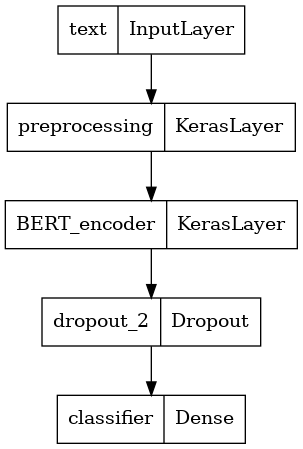

In [20]:
tf.keras.utils.plot_model(classifier_model)

#### Loss function

In [ ]:
# define loss function
#loss = tf.keras.losses.SparseCategoricalCrossentropy()
#metrics = tf.keras.metrics.SparseCategoricalAccuracy()

#### Optimizer

In [25]:
# Convert the pandas DataFrame to a TensorFlow dataset
train_ds = tf.data.Dataset.from_tensor_slices((
    train["text"].values,  # Feature: Text column
    train_labels_int   # Target: One-hot encoded labels
))

# Assuming you have the validation and test datasets similarly
validate_ds = tf.data.Dataset.from_tensor_slices((
    validate["text"].values,
    validate_labels_int
))
test_ds = tf.data.Dataset.from_tensor_slices((
    test["text"].values,
    test_labels_int
))

# Set batch size
BATCH_SIZE = 32
train_ds = train_ds.batch(BATCH_SIZE)
validate_ds = validate_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

# Calculate the steps per epoch
#steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
#num_train_steps = steps_per_epoch * EPOCHS
#num_warmup_steps = int(0.1 * num_train_steps)

for item in train_ds.take(1):
    print(item)

# Create the AdamW optimizer with learning rate scheduling
#init_lr = 3e-5 # started with 3e-5
#optimizer = optimization.create_optimizer(
#    init_lr=init_lr,
#    num_train_steps=num_train_steps,
#    num_warmup_steps=num_warmup_steps,
#    optimizer_type="adamw",
#)

# Compile the model
#classifier_model.compile(
#    optimizer=optimizer,
#    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#    metrics=[tf.keras.metrics.CategoricalAccuracy()]
#)

(<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'Written by\n\nI write to escape, and I read to learn. Each day is taken one step at a time.',
       b'Habits, Routine, and Productivity\n\nI\xe2\x80\x99m not a big fan of plans and goals, because life is too uncertain and unpredictable. In order to be a real overachiever, you should adopt a bottom-up approach, directing your focus to your daily habits.\n\nThe outcomes of your habits build up day after day, yielding immense returns over the long term. It\xe2\x80\x99s up to you whether these daily outcomes are good or bad.\n\nThis story has been published on Better Humans, but it\xe2\x80\x99s too related to the others to be ignored. If the lockdown did a good thing for me, it was giving stability and structure to my routine. I started focusing on good habits that could be easily included in my day until they became my second nature.\n\nIn this story, I share my daily routine while giving you a blueprint to build one for yourself.\n

2025-04-11 15:10:20.110202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [134657]
	 [[{{node Placeholder/_1}}]]


In [26]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Load the model

In [27]:
# classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

NameError: name 'optimizer' is not defined

In [28]:
EPOCHS = 2

print(f"Training model with {tfhub_handle_encoder}")
history = classifier_model.fit(
    x=train_ds, validation_data=validate_ds, epochs=EPOCHS
)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
Epoch 1/2


2025-04-11 15:11:21.458992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [134657]
	 [[{{node Placeholder/_1}}]]
2025-04-11 15:11:21.638297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_1' with dtype int32 and shape [?,128]
	 [[{{node inputs_1}}]]
2025-04-11 15:11:21.638408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_2' with dtype int32 and shape [?,128]
	 [[{{node inpu

  47/4209 [..............................] - ETA: 1:09:31 - loss: 2.3373 - sparse_categorical_accuracy: 0.2314


KeyboardInterrupt



#### Evaluate the model

In [101]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

902/902 [==============================] - 352s 390ms/step - loss: 0.6963 - categorical_accuracy: 0.7835
Loss: 0.6962881088256836
Accuracy: 0.783511221408844


#### Accuracy and loss over time

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


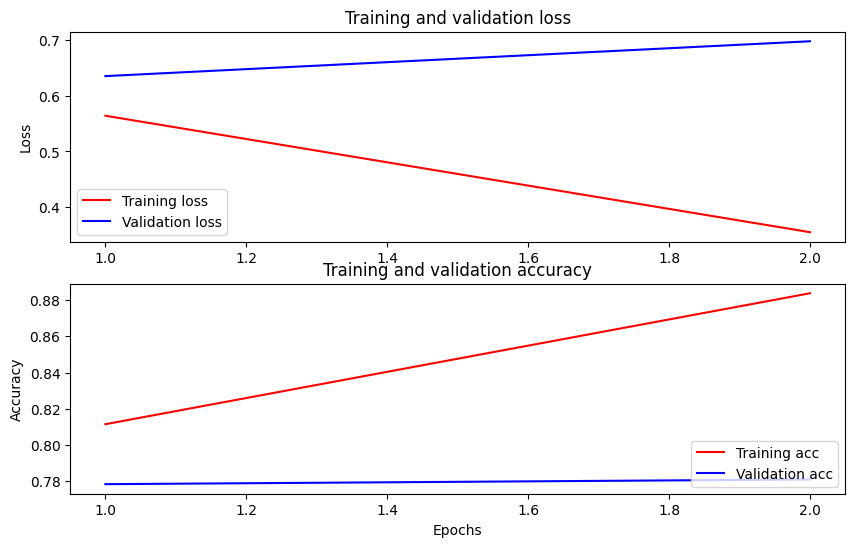

In [103]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict["categorical_accuracy"]
val_acc = history_dict["val_categorical_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, "r", label="Training loss")
# b is for "solid blue line"
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
# plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, "r", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

#### Move the BERT config to a train.py file, create requirements.txt, add csv training file, then Dockerize the working model

##### train.py - model: BERT uncased - encoder-only no fine tuning - minimal (2) epochs

In [2]:
# set os loglevels
import os                                             # to address low-level log output

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # 0=ALL, 1=INFO, 2=WARNING, 3=ERROR
os.environ['GRPC_VERBOSITY'] = 'ERROR'
os.environ['GRPC_CPP_LOG_LEVEL'] = 'ERROR'

# import datetime
import matplotlib.pyplot as plt                       # to generate plot model
import numpy as np                                    # for calculating probabiliy predictions
from official.nlp import optimization                 # to create AdamW optmizer

import pandas as pd                                   # for original data load
# import shutil
from sklearn.model_selection import train_test_split  # to create test splits
import tensorflow as tf                               # needed for working with tensors
import tensorflow_hub as hub                          # for preprocessing (tokenizing???)
import tensorflow_text as text                        # 
from tensorflow.keras.utils import to_categorical

# ---------------
# Variables
# ---------------
DATA_SOURCE = './data/medium.article.topic.csv'
BATCH_SIZE  = 32
EPOCHS      = 2

# ---------------
# Model Encoders and Pre-Processors
# ---------------
MODELS = {
    "BERT": {
        "ENCODER": "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
        "PREPROCESSOR": "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
    },
    "BIGBIRD": {
        "ENCODER": "https://tfhub.dev/google/bigbird-roberta-base/1",
        "PREPROCESSOR": "https://tfhub.dev/google/bigbird-roberta-base-preprocess/1"
    }
}

# use the following model
MODEL = "BERT"

# ---------------
# Runtime Parameters
# ---------------
PREVIEW_SIZE = 5     # number of data rows to display if verbosity >= 4
PRINT        = True  # --- Verbosity levels:
VERBOSITY    = 1     # 0 = minimal output,                 1 = model info, 
SHOW_PLOT    = True  # 2 = display single data card,       3 = show topic labels,   
RUN_ONE_TEST = True  # 4 = preview PREVIEW_SIZE data rows, 5 = confirm GPU

# set tf loglevel
tf.get_logger().setLevel("ERROR")

# ---------------
# do we have a GPU?
# ---------------
if VERBOSITY >= 5:
    tf.config.list_physical_devices('GPU')

# ---------------
# Perform initial Data ETL (Extract, Transform, Load)
# ---------------
# Load Data
bert_df = pd.read_csv(DATA_SOURCE)

# Split into training and temp (validation + test) set (70% train, 30% temp)
train, temp = train_test_split(bert_df, test_size=0.3, random_state=42)

# Split the temp set into validation and test set (50% validation, 50% test of the 30%)
validate, test = train_test_split(temp, test_size=0.5, random_state=42)

# Relabel 'unclassified' entries to 'mature'
for df in (train, validate, test):
    df["topic"] = df["topic"].replace("unclassified", "mature")

# ---------------
# Choose and configure the BERT or BigBird model
# ---------------
tfhub_handle_encoder    = MODELS[MODEL]["ENCODER"]
tfhub_handle_preprocess = MODELS[MODEL]["PREPROCESSOR"]

if VERBOSITY >= 1:
    print(f"Encoder model selected   : {tfhub_handle_encoder}")
    print(f"Preprocess model selected: {tfhub_handle_preprocess}")

# ---------------
# Extract the training labels from the 'topics' column
# ---------------
# Load the BERT preprocessing model
#tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
bert_preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess)

# Assuming 'train', 'validate', 'test' are already loaded dataframes
# Combine all labels from train, validate, and test sets
all_labels = pd.concat([train["topic"], validate["topic"], test["topic"]])

# Create a mapping from topic strings to integers
unique_labels = all_labels.unique()
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
int_to_label = {v: k for k, v in label_to_int.items()}

# Show mapping from string label to integer
if VERBOSITY >= 3:
    print("String to Integer Label Mapping:")
    for label, idx in label_to_int.items():
        print(f"{label!r:25} -> {idx}")

    print("\nInteger to String Label Mapping:")
    for idx, label in int_to_label.items():
        print(f"{idx:2} -> {label!r}")

# ---------------
# BERT encode the labels
# ---------------
# Encode the labels in each dataset
train["label"] = train["topic"].map(label_to_int)
validate["label"] = validate["topic"].map(label_to_int)
test["label"] = test["topic"].map(label_to_int)

if VERBOSITY >= 4:
    print(train[["topic", "label"]].head(25))

# ---------------
# Convert the datasets to TensorFlow datasets
# ---------------
train_dataset = tf.data.Dataset.from_tensor_slices((train["text"].values, train["label"].values))
validate_dataset = tf.data.Dataset.from_tensor_slices((validate["text"].values, validate["label"].values))
test_dataset = tf.data.Dataset.from_tensor_slices((test["text"].values, test["label"].values))

datasets = {
    "Train": train_dataset,
    "Validate": validate_dataset,
    "Test": test_dataset,
}

# potential output validations
if VERBOSITY >= 2:
    # display a data row card profile
    print()
    print(train.iloc[1])

if VERBOSITY >= 4:
    # display 'preview_size' datasets
    def preview_dataset(name, ds, int_to_label, n=PREVIEW_SIZE):
        print(f"--- {name} Dataset Preview ({n} samples) ---")
        for i, (text_tensor, label_tensor) in enumerate(ds.take(n)):
            text = text_tensor.numpy().decode("utf-8")
            label_int = int(label_tensor.numpy())
            label_str = int_to_label[label_int]
            print(f"{i+1}. Text:  {text}")
            print(f"   Label: {label_int} ({label_str})")
            print(f"   ---")
        print()

    for name, ds in datasets.items():
        preview_dataset(name, ds, int_to_label)
            
# ---------------
# Proprocess the tensors
# ---------------
# Label preprocessing
train_labels_int = train["topic"].map(label_to_int).values
validate_labels_int = validate["topic"].map(label_to_int).values
test_labels_int = test["topic"].map(label_to_int).values

num_classes = len(label_to_int)
train_labels_one_hot = to_categorical(train_labels_int, num_classes)
validate_labels_one_hot = to_categorical(validate_labels_int, num_classes)
test_labels_one_hot = to_categorical(test_labels_int, num_classes)

# ---------------
# define, instantiate and compile the training model
# ---------------
# Model builder with softmax output
def build_classifier_model(dropout_rate=0.1):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
    preprocessing_layer = hub.KerasLayer(
        tfhub_handle_preprocess,
        name="preprocessing"
    )
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(
        tfhub_handle_encoder, 
        trainable=False,        # False for rapid prototyping (encoding-only), True for model fine-tuning
        name="Token_encoder"
    )
    outputs = encoder(encoder_inputs)
    
    # Prefer pooled_output if present, otherwise use [CLS] token from last layer
    if "pooled_output" in outputs:
        net = outputs["pooled_output"]
    else:
        net = outputs["encoder_outputs"][-1][:, 0, :]
    
    net = tf.keras.layers.Dropout(dropout_rate)(net)

    # 👇 Updated to num_classes with softmax for multi-class classification
    net = tf.keras.layers.Dense(
        num_classes,
        activation="softmax",
        name="classifier"
    )(net)

    return tf.keras.Model(text_input, net)

# Instantiate the model
dropout_rate = 0.15
classifier_model = build_classifier_model(dropout_rate)

# Compile with appropriate loss
classifier_model.compile(
    optimizer=tf.keras.optimizers.AdamW(),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"]
)

if RUN_ONE_TEST:
    # ---------------
    # single pass sanity check
    # ---------------
    # Optional: test single inference
    text = train["text"].iloc[0]
    pred = classifier_model(tf.constant([text]))
    # print(pred)  # probabilities across all classes

    # Assuming you're running inference on a single example:
    text = train["text"].iloc[0]
    pred = classifier_model(tf.constant([text]))

    # Step 1: Get predicted probabilities
    pred_probabilities = pred.numpy()  # Convert tensor to numpy array

    # Step 2: Find index of highest probability
    predicted_class_idx = np.argmax(pred_probabilities, axis=1)[0]

    # Step 3: Map the index back to the string label
    predicted_class_label = int_to_label[predicted_class_idx]

    # Print the probabilities and the predicted label
    print(f"Predicted Probabilities: {pred_probabilities}")
    print(f"Predicted Label: {predicted_class_label}")

# ---------------
# Display model plot
# ---------------
if SHOW_PLOT:
    tf.keras.utils.plot_model(classifier_model)

# ---------------
# Optimizer
# ---------------
# Convert the pandas DataFrames to a TensorFlow for each dataset
train_ds = tf.data.Dataset.from_tensor_slices((
    train["text"].values,  # Training feature: Text column
    train_labels_int       # Target: integer encoded labels
))

validate_ds = tf.data.Dataset.from_tensor_slices((
    validate["text"].values,
    validate_labels_int
))

test_ds = tf.data.Dataset.from_tensor_slices((
    test["text"].values,
    test_labels_int
))

# Set batch size for each dataset
train_ds = train_ds.batch(BATCH_SIZE)
validate_ds = validate_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

# conditionally display validation row for training dataset
if VERBOSITY >= 2:
    print(f"Row one of training dataset")
    for item in train_ds.take(1):
        print(item)

# ---------------
# Train the model
# ---------------
if VERBOSITY >= 1:
    print(f"Training model with {tfhub_handle_encoder}")

history = classifier_model.fit(
    x=train_ds, 
    validation_data=validate_ds, 
    epochs=EPOCHS
)

# ---------------
# Evaluate the model
# ---------------
loss, accuracy = classifier_model.evaluate(test_ds)

if VERBOSITY >= 1:
    print(f"Loss: {loss}")
    print(f"Accuracy: {accuracy}")
    
# ---------------
# Calculate accuracy and loss over time
# ---------------
history_dict = history.history
if VERBOSITY >= 1:
    print(history_dict.keys())

acc = history_dict["sparse_categorical_accuracy"]
val_acc = history_dict["val_sparse_categorical_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

if SHOW_PLOT:
    plt.subplot(2, 1, 1)
    # "bo" is for "blue dot"
    plt.plot(epochs, loss, "r", label="Training loss")
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    # plt.xlabel('Epochs')
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, "r", label="Training acc")
    plt.plot(epochs, val_acc, "b", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

Encoder model selected        : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3
Predicted Probabilities: [[0.0987445  0.06452634 0.06612883 0.01466486 0.21846369 0.0178917
  0.02520433 0.07185609 0.01869069 0.01239328 0.00703997 0.00928353
  0.01196875 0.00957768 0.06152138 0.12363267 0.16841178]]
Predicted Label: technology
Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
Epoch 1/2
4209/4209 [==============================] - 1977s 468ms/step - loss: 1.4702 - sparse_categorical_accuracy: 0.5301 - val_loss: 1.1872 - val_sparse_categorical_accuracy: 0.6137
Epoch 2/2
902/902 [==============================] - 347s 385ms/step - loss: 1.0942 - sparse_categorical_accuracy: 0.6398
Loss: 1.0942347049713135
Accuracy: 0.6397629380226135
dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


KeyError: 'categorical_accuracy'

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


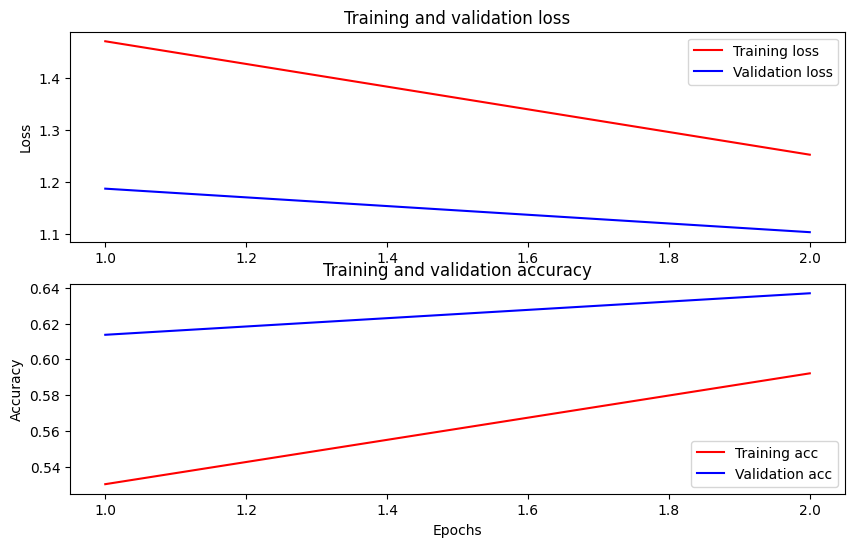

In [4]:
# ---------------
# Calculate accuract and loss over time
# ---------------
history_dict = history.history
if VERBOSITY >= 1:
    print(history_dict.keys())

acc = history_dict["sparse_categorical_accuracy"]
val_acc = history_dict["val_sparse_categorical_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

if SHOW_PLOT:
    plt.subplot(2, 1, 1)
    # "bo" is for "blue dot"
    plt.plot(epochs, loss, "r", label="Training loss")
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    # plt.xlabel('Epochs')
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, "r", label="Training acc")
    plt.plot(epochs, val_acc, "b", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

##### train.py - model: BERT - encoder-only no fine-tuning - expanded to batch_size 128 epochs 16 with early stopping

In [ ]:
# set os loglevels
import os                                             # to address low-level log output

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # 0=ALL, 1=INFO, 2=WARNING, 3=ERROR
os.environ['GRPC_VERBOSITY'] = 'ERROR'
os.environ['GRPC_CPP_LOG_LEVEL'] = 'ERROR'

# import datetime
import matplotlib.pyplot as plt                       # to generate plot model
import numpy as np                                    # for calculating probabiliy predictions
from official.nlp import optimization                 # to create AdamW optmizer

import pandas as pd                                   # for original data load
# import shutil
from sklearn.model_selection import train_test_split  # to create test splits
import tensorflow as tf                               # needed for working with tensors
import tensorflow_hub as hub                          # for preprocessing (tokenizing???)
import tensorflow_text as text                        # for text processing
from tensorflow.keras.callbacks import EarlyStopping  # to stop training when no improvement

# ---------------
# Variables
# ---------------
DATA_SOURCE = './data/medium.article.topic.csv'
BATCH_SIZE  = 128  # Larger batch size for faster training
EPOCHS      = 16   # Allow up to 16 epochs, with early stopping to prevent overfitting

# ---------------
# Model Encoders and Pre-Processors
# ---------------
MODELS = {
    "BERT": {
        "ENCODER": "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
        "PREPROCESSOR": "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
    },
    "BIGBIRD": {
        "ENCODER": "https://tfhub.dev/google/bigbird-roberta-base/1",
        "PREPROCESSOR": "https://tfhub.dev/google/bigbird-roberta-base-preprocess/1"
    }
}

# use the following model
MODEL = "BERT"

# ---------------
# Runtime Parameters
# ---------------
PREVIEW_SIZE = 5     # number of data rows to display if verbosity >= 4
PRINT        = True  # --- Verbosity levels:
VERBOSITY    = 1     # 0 = minimal output,                 1 = model info,
SHOW_PLOT    = True  # 2 = display single data card,       3 = show topic labels,
RUN_ONE_TEST = True  # 4 = preview PREVIEW_SIZE data rows, 5 = confirm GPU

# set tf loglevel
tf.get_logger().setLevel("ERROR")

# ---------------
# do we have a GPU?
# ---------------
if VERBOSITY >= 5:
    tf.config.list_physical_devices('GPU')

# ---------------
# Perform initial Data ETL (Extract, Transform, Load)
# ---------------
# Load Data
bert_df = pd.read_csv(DATA_SOURCE)

# Split into training and temp (validation + test) set (70% train, 30% temp)
train, temp = train_test_split(bert_df, test_size=0.3, random_state=42)

# Split the temp set into validation and test set (50% validation, 50% test of the 30%)
validate, test = train_test_split(temp, test_size=0.5, random_state=42)

# Relabel 'unclassified' entries to 'mature'
for df in (train, validate, test):
    df["topic"] = df["topic"].replace("unclassified", "mature")

# ---------------
# Choose and configure the BERT or BigBird model
# ---------------
tfhub_handle_encoder    = MODELS[MODEL]["ENCODER"]
tfhub_handle_preprocess = MODELS[MODEL]["PREPROCESSOR"]

if VERBOSITY >= 1:
    print(f"Encoder model selected   : {tfhub_handle_encoder}")
    print(f"Preprocess model selected: {tfhub_handle_preprocess}")

# ---------------
# Extract the training labels from the 'topics' column
# ---------------
# Load the BERT preprocessing model
#tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
bert_preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess)

# Assuming 'train', 'validate', 'test' are already loaded dataframes
# Combine all labels from train, validate, and test sets
all_labels = pd.concat([train["topic"], validate["topic"], test["topic"]])

# Create a mapping from topic strings to integers
unique_labels = all_labels.unique()
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
int_to_label = {v: k for k, v in label_to_int.items()}

# Show mapping from string label to integer
if VERBOSITY >= 3:
    print("String to Integer Label Mapping:")
    for label, idx in label_to_int.items():
        print(f"{label!r:25} -> {idx}")

    print("\nInteger to String Label Mapping:")
    for idx, label in int_to_label.items():
        print(f"{idx:2} -> {label!r}")

# ---------------
# BERT encode the labels
# ---------------
# Encode the labels in each dataset
train["label"] = train["topic"].map(label_to_int)
validate["label"] = validate["topic"].map(label_to_int)
test["label"] = test["topic"].map(label_to_int)

if VERBOSITY >= 4:
    print(train[["topic", "label"]].head(25))

# ---------------
# Convert the datasets to TensorFlow datasets
# ---------------
train_dataset = tf.data.Dataset.from_tensor_slices((train["text"].values, train["label"].values))
validate_dataset = tf.data.Dataset.from_tensor_slices((validate["text"].values, validate["label"].values))
test_dataset = tf.data.Dataset.from_tensor_slices((test["text"].values, test["label"].values))

datasets = {
    "Train": train_dataset,
    "Validate": validate_dataset,
    "Test": test_dataset,
}

# potential output validations
if VERBOSITY >= 2:
    # display a data row card profile
    print()
    print(train.iloc[1])

if VERBOSITY >= 4:
    # display 'preview_size' datasets
    def preview_dataset(name, ds, int_to_label, n=PREVIEW_SIZE):
        print(f"--- {name} Dataset Preview ({n} samples) ---")
        for i, (text_tensor, label_tensor) in enumerate(ds.take(n)):
            text = text_tensor.numpy().decode("utf-8")
            label_int = int(label_tensor.numpy())
            label_str = int_to_label[label_int]
            print(f"{i+1}. Text:  {text}")
            print(f"   Label: {label_int} ({label_str})")
            print(f"   ---")
        print()

    for name, ds in datasets.items():
        preview_dataset(name, ds, int_to_label)

# ---------------
# Proprocess the tensors
# ---------------
# Label preprocessing
train_labels_int = train["topic"].map(label_to_int).values
validate_labels_int = validate["topic"].map(label_to_int).values
test_labels_int = test["topic"].map(label_to_int).values

num_classes = len(label_to_int)
train_labels_one_hot = to_categorical(train_labels_int, num_classes)
validate_labels_one_hot = to_categorical(validate_labels_int, num_classes)
test_labels_one_hot = to_categorical(test_labels_int, num_classes)

# ---------------
# define, instantiate and compile the training model
# ---------------
# Model builder with softmax output
def build_classifier_model(dropout_rate=0.1):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
    preprocessing_layer = hub.KerasLayer(
        tfhub_handle_preprocess,
        name="preprocessing"
    )
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(
        tfhub_handle_encoder,
        trainable=False,        # False for rapid prototyping (encoding-only), True for model fine-tuning
        name="Token_encoder"
    )
    outputs = encoder(encoder_inputs)

    # Prefer pooled_output if present, otherwise use [CLS] token from last layer
    if "pooled_output" in outputs:
        net = outputs["pooled_output"]
    else:
        net = outputs["encoder_outputs"][-1][:, 0, :]

    net = tf.keras.layers.Dropout(dropout_rate)(net)

    # 👇 Updated to num_classes with softmax for multi-class classification
    net = tf.keras.layers.Dense(
        num_classes,
        activation="softmax",
        name="classifier"
    )(net)

    return tf.keras.Model(text_input, net)

# Instantiate the model
dropout_rate = 0.15
classifier_model = build_classifier_model(dropout_rate)

# Compile with appropriate loss
classifier_model.compile(
    optimizer=tf.keras.optimizers.AdamW(),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"]
)

if RUN_ONE_TEST:
    # ---------------
    # single pass sanity check
    # ---------------
    # Optional: test single inference
    text = train["text"].iloc[0]
    pred = classifier_model(tf.constant([text]))
    # print(pred)  # probabilities across all classes

    # Assuming you're running inference on a single example:
    text = train["text"].iloc[0]
    pred = classifier_model(tf.constant([text]))

    # Step 1: Get predicted probabilities
    pred_probabilities = pred.numpy()  # Convert tensor to numpy array

    # Step 2: Find index of highest probability
    predicted_class_idx = np.argmax(pred_probabilities, axis=1)[0]

    # Step 3: Map the index back to the string label
    predicted_class_label = int_to_label[predicted_class_idx]

    # Print the probabilities and the predicted label
    print(f"Predicted Probabilities: {pred_probabilities}")
    print(f"Predicted Label: {predicted_class_label}")

# ---------------
# Display model plot
# ---------------
if SHOW_PLOT:
    tf.keras.utils.plot_model(classifier_model)

# ---------------
# Optimizer
# ---------------
# Convert the pandas DataFrames to a TensorFlow for each dataset
train_ds = tf.data.Dataset.from_tensor_slices((
    train["text"].values,  # Training feature: Text column
    train_labels_int       # Target: integer encoded labels
))

validate_ds = tf.data.Dataset.from_tensor_slices((
    validate["text"].values,
    validate_labels_int
))

test_ds = tf.data.Dataset.from_tensor_slices((
    test["text"].values,
    test_labels_int
))

# Set batch size for each dataset
train_ds = train_ds.batch(BATCH_SIZE)
validate_ds = validate_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

# conditionally display validation row for training dataset
if VERBOSITY >= 2:
    print(f"Row one of training dataset")
    for item in train_ds.take(1):
        print(item)

# ---------------
# Train the model with EarlyStopping
# ---------------
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor validation loss
    patience=3,          # Stop training after 3 epochs of no improvement
    restore_best_weights=True  # Restore the weights of the best epoch
)

if VERBOSITY >= 1:
    print(f"Training model with {tfhub_handle_encoder} and EarlyStopping")

history = classifier_model.fit(
    x=train_ds,
    validation_data=validate_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping]  # Add the EarlyStopping callback here
)
# ---------------
# Evaluate the model
# ---------------
loss, accuracy = classifier_model.evaluate(test_ds)

if VERBOSITY >= 1:
    print(f"Loss: {loss}")
    print(f"Accuracy: {accuracy}")

# ---------------
# Calculate accuracy and loss over time
# ---------------
history_dict = history.history
if VERBOSITY >= 1:
    print(history_dict.keys())

acc = history_dict["sparse_categorical_accuracy"]
val_acc = history_dict["val_sparse_categorical_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

if SHOW_PLOT:
    plt.subplot(2, 1, 1)
    # "bo" is for "blue dot"
    plt.plot(epochs, loss, "r", label="Training loss")
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    # plt.xlabel('Epochs')
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, "r", label="Training acc")
    plt.plot(epochs, val_acc, "b", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")


##### train.py - model: BigBird - encoder-only no fine tuning - minimal (2) epochs

In [10]:
# set os loglevels
import os                                             # to address low-level log output

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # 0=ALL, 1=INFO, 2=WARNING, 3=ERROR
os.environ['GRPC_VERBOSITY'] = 'ERROR'
os.environ['GRPC_CPP_LOG_LEVEL'] = 'ERROR'

# import datetime
import matplotlib.pyplot as plt                       # to generate plot model
import numpy as np                                    # for calculating probabiliy predictions
from official.nlp import optimization                 # to create AdamW optmizer

import pandas as pd                                   # for original data load
# import shutil
from sklearn.model_selection import train_test_split  # to create test splits
import tensorflow as tf                               # needed for working with tensors
import tensorflow_hub as hub                          # for preprocessing (tokenizing???)
import tensorflow_text as text                        #
from tensorflow.keras.utils import to_categorical

# ---------------
# Variables
# ---------------
DATA_SOURCE = './data/medium.article.topic.csv'
BATCH_SIZE  = 32
EPOCHS      = 2

# ---------------
# Model Encoders and Pre-Processors
# ---------------
MODELS = {
    "BERT": {
        "ENCODER": "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
        "PREPROCESSOR": "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
    },
    "BIGBIRD": {
        "ENCODER": "https://tfhub.dev/google/bigbird-roberta-base/1",
        "PREPROCESSOR": "https://tfhub.dev/google/bigbird-roberta-base-preprocess/1"
    }
}

# use the following model
MODEL = "BIGBIRD"

# ---------------
# Runtime Parameters
# ---------------
PREVIEW_SIZE = 5     # number of data rows to display if verbosity >= 4
PRINT        = True  # --- Verbosity levels:
VERBOSITY    = 1     # 0 = minimal output,                 1 = model info,
SHOW_PLOT    = True  # 2 = display single data card,       3 = show topic labels,
RUN_ONE_TEST = True  # 4 = preview PREVIEW_SIZE data rows, 5 = confirm GPU

# set tf loglevel
tf.get_logger().setLevel("ERROR")

# ---------------
# do we have a GPU?
# ---------------
if VERBOSITY >= 5:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"GPUs available: {gpus}")
    else:
        print("No GPUs available.")

# ---------------
# Perform initial Data ETL (Extract, Transform, Load)
# ---------------
# Load Data
bert_df = pd.read_csv(DATA_SOURCE)

# Split into training and temp (validation + test) set (70% train, 30% temp)
train, temp = train_test_split(bert_df, test_size=0.3, random_state=42)

# Split the temp set into validation and test set (50% validation, 50% test of the 30%)
validate, test = train_test_split(temp, test_size=0.5, random_state=42)

# Relabel 'unclassified' entries to 'mature'
for df in (train, validate, test):
    df["topic"] = df["topic"].replace("unclassified", "mature")

# ---------------
# Choose and configure the BERT or BigBird model
# ---------------
if MODEL == "BERT":
    bert_preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess)
    if VERBOSITY >= 1:
        print("Using TensorFlow Hub preprocessing layer for BERT.")
else:
    from transformers import AutoTokenizer, TFAutoModel

    tokenizer = AutoTokenizer.from_pretrained("google/bigbird-roberta-base")
    if VERBOSITY >= 1:
        print("Using Hugging Face tokenizer for BigBird.")

# ---------------
# Extract the training labels from the 'topics' column
# ---------------
# Assuming 'train', 'validate', 'test' are already loaded dataframes
# Combine all labels from train, validate, and test sets
all_labels = pd.concat([train["topic"], validate["topic"], test["topic"]])

# Create a mapping from topic strings to integers
unique_labels = all_labels.unique()
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
int_to_label = {v: k for k, v in label_to_int.items()}

# Show mapping from string label to integer
if VERBOSITY >= 3:
    print("String to Integer Label Mapping:")
    for label, idx in label_to_int.items():
        print(f"{label!r:25} -> {idx}")

    print("\nInteger to String Label Mapping:")
    for idx, label in int_to_label.items():
        print(f"{idx:2} -> {label!r}")

# ---------------
# Model encode the labels
# ---------------
# Encode the labels in each dataset
train["label"] = train["topic"].map(label_to_int)
validate["label"] = validate["topic"].map(label_to_int)
test["label"] = test["topic"].map(label_to_int)

if VERBOSITY >= 4:
    print(train[["topic", "label"]].head(25))

# ---------------
# Convert the datasets to TensorFlow datasets
# ---------------
train_dataset = tf.data.Dataset.from_tensor_slices((train["text"].values, train["label"].values))
validate_dataset = tf.data.Dataset.from_tensor_slices((validate["text"].values, validate["label"].values))
test_dataset = tf.data.Dataset.from_tensor_slices((test["text"].values, test["label"].values))

datasets = {
    "Train": train_dataset,
    "Validate": validate_dataset,
    "Test": test_dataset,
}

# potential output validations
if VERBOSITY >= 2:
    # display a data row card profile
    print()
    print(train.iloc[1])

if VERBOSITY >= 4:
    # display 'preview_size' datasets
    def preview_dataset(name, ds, int_to_label, n=PREVIEW_SIZE):
        print(f"--- {name} Dataset Preview ({n} samples) ---")
        for i, (text_tensor, label_tensor) in enumerate(ds.take(n)):
            text = text_tensor.numpy().decode("utf-8")
            label_int = int(label_tensor.numpy())
            label_str = int_to_label[label_int]
            print(f"{i+1}. Text:  {text}")
            print(f"   Label: {label_int} ({label_str})")
            print(f"   ---")
        print()

    for name, ds in datasets.items():
        preview_dataset(name, ds, int_to_label)

# ---------------
# Proprocess the tensors
# ---------------
# Label preprocessing
train_labels_int = train["topic"].map(label_to_int).values
validate_labels_int = validate["topic"].map(label_to_int).values
test_labels_int = test["topic"].map(label_to_int).values

num_classes = len(label_to_int)
train_labels_one_hot = to_categorical(train_labels_int, num_classes)
validate_labels_one_hot = to_categorical(validate_labels_int, num_classes)
test_labels_one_hot = to_categorical(test_labels_int, num_classes)

# ---------------
# define unified encoding function
# ---------------
def encode_texts(texts, model_name):
    """
    Encodes texts based on the selected model (BERT or BigBird).
    """
    if model_name == "BERT":
        # TensorFlow Hub preprocessing for BERT
        return bert_preprocessing_layer(tf.convert_to_tensor(texts))
    elif model_name == "BIGBIRD":
        # Hugging Face tokenizer for BigBird
        return tokenizer(
            texts,
            padding=True,
            truncation=True,
            return_tensors="tf"
        )
    else:
        raise ValueError(f"Unsupported model: {model_name}")

# ---------------
# define, instantiate and compile the training model
# ---------------
# ...existing code...

def build_classifier_model(model_name, dropout_rate=0.1):
    """
    Builds a classifier model based on the selected model (BERT or BigBird).
    """
    if model_name == "BERT":
        # TensorFlow Hub setup for BERT
        text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")

        preprocessing_layer = hub.KerasLayer(
            MODELS["BERT"]["PREPROCESSOR"],
            name="preprocessing"
        )
        encoder_inputs = preprocessing_layer(text_input)

        encoder = hub.KerasLayer(
            MODELS["BERT"]["ENCODER"],
            trainable=False,
            name="Token_encoder"
        )

        outputs = encoder(encoder_inputs)
        model_input = text_input

    elif model_name == "BIGBIRD":
        # Hugging Face setup for BigBird
        input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="input_ids")
        attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="attention_mask")

        encoder = TFAutoModel.from_pretrained("google/bigbird-roberta-base", trainable=False)

        outputs = encoder({
            "input_ids": input_ids,
            "attention_mask": attention_mask
        })
        model_input = [input_ids, attention_mask]

    else:
        raise ValueError(f"Unsupported model: {model_name}")

    # Select pooled_output or fallback to [CLS] token
    if hasattr(outputs, "pooler_output"):
        net = outputs.pooler_output
    elif isinstance(outputs, dict) and "pooled_output" in outputs:
        net = outputs["pooled_output"]
    else:
        # Fallback for models like RoBERTa without pooled output
        net = outputs.last_hidden_state[:, 0, :] if hasattr(outputs, "last_hidden_state") else outputs["encoder_outputs"][-1][:, 0, :]

    net = tf.keras.layers.Dropout(dropout_rate)(net)
    net = tf.keras.layers.Dense(num_classes, activation="softmax", name="classifier")(net)

    return tf.keras.Model(inputs=model_input, outputs=net)

# Instantiate the model based on the selected MODEL
classifier_model = build_classifier_model(MODEL, dropout_rate=0.15)

# Compile the model
classifier_model.compile(
    optimizer=tf.keras.optimizers.AdamW(),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"]
)

if RUN_ONE_TEST:
    # Single pass sanity check
    text = train["text"].iloc[0]

    if MODEL == "BERT":
        pred = classifier_model(tf.constant([text]))
    elif MODEL == "BIGBIRD":
        encoded_text = tokenizer(
            [text],
            padding=True,
            truncation=True,
            return_tensors="tf"
        )
        pred = classifier_model(encoded_text)

    # Step 1: Get predicted probabilities
    pred_probabilities = pred.numpy()  # Convert tensor to numpy array

    # Step 2: Find index of highest probability
    predicted_class_idx = np.argmax(pred_probabilities, axis=1)[0]

    # Step 3: Map the index back to the string label
    predicted_class_label = int_to_label[predicted_class_idx]

    # Print the probabilities and the predicted label
    print(f"Predicted Probabilities: {pred_probabilities}")
    print(f"Predicted Label: {predicted_class_label}")

# ---------------
# Display model plot
# ---------------
if SHOW_PLOT and MODEL == "BERT":
    tf.keras.utils.plot_model(classifier_model)

# ---------------
# Optimizer
# ---------------
if MODEL == "BERT":
    # Convert the pandas DataFrames to a TensorFlow for each dataset
    train_ds = tf.data.Dataset.from_tensor_slices((
        train["text"].values,  # Training feature: Text column
        train_labels_int       # Target: integer encoded labels
    ))

    validate_ds = tf.data.Dataset.from_tensor_slices((
        validate["text"].values,
        validate_labels_int
    ))

    test_ds = tf.data.Dataset.from_tensor_slices((
        test["text"].values,
        test_labels_int
    ))
elif MODEL == "BIGBIRD":
    train_encodings = encode_texts(train["text"].tolist(), MODEL)
    validate_encodings = encode_texts(validate["text"].tolist(), MODEL)
    test_encodings = encode_texts(test["text"].tolist(), MODEL)

    # Convert to TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((
        {
            "input_ids": train_encodings["input_ids"],
            "attention_mask": train_encodings["attention_mask"]
        },
        train_labels_int
    ))

    validate_ds = tf.data.Dataset.from_tensor_slices((
        {
            "input_ids": validate_encodings["input_ids"],
            "attention_mask": validate_encodings["attention_mask"]
        },
        validate_labels_int
    ))

    test_ds = tf.data.Dataset.from_tensor_slices((
        {
            "input_ids": test_encodings["input_ids"],
            "attention_mask": test_encodings["attention_mask"]
        },
        test_labels_int
    ))
else:
    raise ValueError(f"Unsupported model: {MODEL}")

# Set size and batch each dataset
train_ds = train_ds.batch(BATCH_SIZE)
validate_ds = validate_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

# conditionally display validation row for training dataset
if VERBOSITY >= 2:
    print(f"Row one of training dataset")
    for item in train_ds.take(1):
        print(item)

if VERBOSITY >= 1:
    if MODEL == "BERT":
        print("BERT preprocessing and model setup complete.")
    elif MODEL == "BIGBIRD":
        print("BigBird tokenizer and model setup complete.")

# ---------------
# Train the model
# ---------------
if VERBOSITY >= 1:
    print(f"Training model with {MODEL}")

history = classifier_model.fit(
    x=train_ds,
    validation_data=validate_ds,
    epochs=EPOCHS
)
# ---------------
# Evaluate the model
# ---------------
loss, accuracy = classifier_model.evaluate(test_ds)

if VERBOSITY >= 1:
    print(f"Loss: {loss}")
    print(f"Accuracy: {accuracy}")

# ---------------
# Calculate accuracy and loss over time
# ---------------
history_dict = history.history
if VERBOSITY >= 1:
    print(history_dict.keys())

acc = history_dict["sparse_categorical_accuracy"]
val_acc = history_dict["val_sparse_categorical_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

if SHOW_PLOT:
    plt.subplot(2, 1, 1)
    # "bo" is for "blue dot"
    plt.plot(epochs, loss, "r", label="Training loss")
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    # plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, "r", label="Training acc")
    plt.plot(epochs, val_acc, "b", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    

Using Hugging Face tokenizer for BigBird.


ValueError: Unrecognized configuration class <class 'transformers.models.big_bird.configuration_big_bird.BigBirdConfig'> for this kind of AutoModel: TFAutoModel.
Model type should be one of AlbertConfig, BartConfig, BertConfig, BlenderbotConfig, BlenderbotSmallConfig, BlipConfig, CamembertConfig, CLIPConfig, ConvBertConfig, ConvNextConfig, ConvNextV2Config, CTRLConfig, CvtConfig, Data2VecVisionConfig, DebertaConfig, DebertaV2Config, DeiTConfig, DistilBertConfig, DPRConfig, EfficientFormerConfig, ElectraConfig, EsmConfig, FlaubertConfig, FunnelConfig, GPT2Config, GPT2Config, GPTJConfig, GroupViTConfig, HubertConfig, IdeficsConfig, LayoutLMConfig, LayoutLMv3Config, LEDConfig, LongformerConfig, LxmertConfig, MarianConfig, MBartConfig, MistralConfig, MobileBertConfig, MobileViTConfig, MPNetConfig, MT5Config, OpenAIGPTConfig, OPTConfig, PegasusConfig, RegNetConfig, RemBertConfig, ResNetConfig, RobertaConfig, RobertaPreLayerNormConfig, RoFormerConfig, SamConfig, SamVisionConfig, SegformerConfig, Speech2TextConfig, SwiftFormerConfig, SwinConfig, T5Config, TapasConfig, TransfoXLConfig, VisionTextDualEncoderConfig, ViTConfig, ViTMAEConfig, Wav2Vec2Config, WhisperConfig, XGLMConfig, XLMConfig, XLMRobertaConfig, XLNetConfig.

##### requirements.txt

##### Dockerfile

In [ ]:
FROM tensorflow/tensorflow:2.15.0-gpu

# Set working dir
WORKDIR /app

# Install dependencies
COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

# Add your training code
COPY . .

# Run training
CMD ["python", "train.py", "--epochs", "50"]

#### Test docker container locally

#### Setup Kubeflow pipeline

##### Terraform

In [ ]:
apiVersion: kubeflow.org/v1
kind: TFJob
metadata:
  name: bert-finetune-job
spec:
  tfReplicaSpecs:
    Worker:
      replicas: 6
      restartPolicy: OnFailure
      template:
        spec:
          containers:
            - name: tensorflow
              image: gcr.io/YOUR_PROJECT_ID/bert-finetune:latest
              command: ["python", "train.py"]
              env:
                - name: GOOGLE_APPLICATION_CREDENTIALS
                  value: /secret/gcp/key.json
              volumeMounts:
                - name: gcp-key
                  mountPath: /secret/gcp
              resources:
                limits:
                  nvidia.com/gpu: 2
                  memory: "32Gi"
                  cpu: "8"
          volumes:
            - name: gcp-key
              secret:
                secretName: gcp-sa-key

<hr>

### Frame optimization below this line is from earlier iteration of article classifier

#### Calculate optimized frame size

In [ ]:
from transformers import BertTokenizer
import numpy as np

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def get_token_lengths(text_batches):
    # Convert TensorFlow tensors to strings and tokenize
    return [len(tokenizer.tokenize(text.numpy().decode('utf-8'))) for text in text_batches]

# Initialize the lists to collect token lengths
token_lengths = []

# Iterate through a single batch of data in raw_train_ds
for text_batch, label_batch in raw_train_ds.take(1):  # Assuming raw_train_ds is the dataset you've prepared
    # Get token lengths for this batch of texts
    token_lengths.extend(get_token_lengths(text_batch))

# Analyze the token lengths
print("Token count stats:")
print(f"Mean      : {np.mean(token_lengths):.1f}")
print(f"Median    : {np.median(token_lengths):.1f}")
print(f"95th perc : {np.percentile(token_lengths, 95):.0f}")
print(f"Max       : {np.max(token_lengths)}")

# Print dataset sizes
print(f"Train samples: {train.shape[0]}")
print(f"Validation samples: {validate.shape[0]}")
print(f"Test samples: {test.shape[0]}")

SANITY_CHECK = False

if SANITY_CHECK:
    # Sanity check by printing a few text examples from the batch
    class_names = label_encoder.classes_


    for text_batch, label_batch in raw_train_ds.take(1):
        for i in range(3):
            print(f"Text  : {text_batch.numpy()[i].decode('utf-8')}")
            label = label_batch.numpy()[i]
            print(f"Label : {label} ({class_names[label]})")
            print("---")

Based upon 95th Perc and Max Size, max_chunks=5

#### Sport and Score Extractor

input: article body  
output: identified sport, score summary

In [ ]:

# Import necessary modules from pydantic
from pydantic import BaseModel, Extra
from typing import Dict, Any
import pandas as pd  # Assuming you're using pandas for the test dataframe

# Define the Schema class
class Schema(BaseModel):
    type: str
    properties: Dict[str, Any]
    required: list

# Define the FunctionDeclarationWithExtra class
class FunctionDeclarationWithExtra(BaseModel):
    name: str
    description: str
    parameters: Schema
    # Allow extra fields (like PROMPT)
    class Config:
        extra = Extra.allow

# Define the function declaration for score extraction
score_extraction_func = FunctionDeclarationWithExtra(
    name="score_extraction",
    description="Extract the scores from the article if feasible",
    parameters=Schema(
        type="OBJECT",
        properties={
            "article_text": {  # Define the expected 'article_text' input
                "type": "STRING",
                "description": "The content of the article to extract scores."
            },
            "score_available": {
                "type": "BOOLEAN",
                "description": "Indicates if scores are available in the article."
            },
            "team1_score": {
                "type": "INTEGER",
                "description": "Score for team 1 if available."
            },
            "team2_score": {
                "type": "INTEGER",
                "description": "Score for team 2 if available."
            },
            "team1_name": {
                "type": "STRING",
                "description": "Name of team 1 if mentioned."
            },
            "team2_name": {
                "type": "STRING",
                "description": "Name of team 2 if mentioned."
            },
        },
        required=["article_text", "score_available"],
    ),
    PROMPT="""
    Given the following article, extract the score if feasible:

    {article_text}

    Provide the output in a structured JSON format:
    {{
        "score_available": true/false,
        "team1_name": "name_of_team1",
        "team1_score": score_of_team1,
        "team2_name": "name_of_team2",
        "team2_score": score_of_team2
    }}
    """
)

def extract_scores_from_article(article_text: str):
    # Dynamically set the prompt with the actual article text
    formatted_prompt = score_extraction_func.PROMPT.format(article_text=article_text)

    # Example client and content generation logic (ensure the client and model are correctly defined)
    response = client.models.generate_content(
        model=MODEL,
        contents=formatted_prompt,
        config=GenerateContentConfig(
            response_mime_type="application/json",
            response_schema={
                "type": "OBJECT",
                "properties": {
                    "score_available": {
                        "type": "BOOLEAN",
                    },
                    "team1_name": {
                        "type": "STRING",
                    },
                    "team1_score": {
                        "type": "INTEGER",
                    },
                    "team2_name": {
                        "type": "STRING",
                    },
                    "team2_score": {
                        "type": "INTEGER",
                    }
                },
                "required": ["score_available"],
            },
        ),
    )

    # The response contains the scores extracted from the article
    scores_extraction_result = json.loads(response.json())  # Parse the JSON response

    return scores_extraction_result

# Loop through the test dataframe and extract scores
for idx, row in test.head(2000).iterrows():  # Adjust the dataframe as necessary
    article_text = row["text"]
    extracted_scores = extract_scores_from_article(article_text)
    actual_tags = row["tags"]  # Get the tags for the current row

    if extracted_scores.get("score_available"):
        print(f"Extracted Scores: {extracted_scores}\t\tActual tags: {actual_tags}")

#### Sport Statistics Summarizer

input: article body  
output: statistics summary

In [ ]:

# Import necessary modules from pydantic
from pydantic import BaseModel, Extra
from typing import Dict, Any
import pandas as pd  # Assuming you're using pandas for the test dataframe
import json

# Define the Schema class
class Schema(BaseModel):
    type: str
    properties: Dict[str, Any]
    required: list

# Define the FunctionDeclarationWithExtra class
class FunctionDeclarationWithExtra(BaseModel):
    name: str
    description: str
    parameters: Schema
    # Allow extra fields (like PROMPT)
    class Config:
        extra = Extra.allow

# Define the function declaration for sport mention and person summary extraction
sport_person_extraction_func = FunctionDeclarationWithExtra(
    name="sport_person_extraction",
    description="Extract mentions of sports and summarize information related to individuals mentioned in the article if feasible",
    parameters=Schema(
        type="OBJECT",
        properties={
            "article_text": {  # Define the expected 'article_text' input
                "type": "STRING",
                "description": "The content of the article to extract sport mentions and person summaries."
            },
            "sport_mentioned": {
                "type": "BOOLEAN",
                "description": "Indicates if any sports are mentioned in the article."
            },
            "person_name": {
                "type": "STRING",
                "description": "Name of the person mentioned in relation to the sport."
            },
            "summary": {
                "type": "STRING",
                "description": "Summary of what is said about the person."
            },
        },
        required=["article_text", "sport_mentioned"],
    ),
    PROMPT="""
    Given the following article, identify if any sports are mentioned. If there are mentions of sports, find any names attached to the article and provide a summary about what the article is saying about that person.

    {article_text}

    Provide the output in a structured JSON format:
    {{
        "sport_mentioned": true/false,
        "person_name": "name_of_person_mentioned",
        "summary": "summary_about_person"
    }}
    """
)

def extract_sport_person_summary_from_article(article_text: str):
    # Dynamically set the prompt with the actual article text
    formatted_prompt = sport_person_extraction_func.PROMPT.format(article_text=article_text)

    # Example client and content generation logic (ensure the client and model are correctly defined)
    response = client.models.generate_content(
        model=MODEL,  # Make sure to replace with the actual model name you are using
        contents=formatted_prompt,
        config=GenerateContentConfig(
            response_mime_type="application/json",
            response_schema={
                "type": "OBJECT",
                "properties": {
                    "sport_mentioned": {
                        "type": "BOOLEAN",
                    },
                    "person_name": {
                        "type": "STRING",
                    },
                    "summary": {
                        "type": "STRING",
                    }
                },
                "required": ["sport_mentioned"],
            },
        ),
    )

    # Parse the JSON response
    response_data = json.loads(response.json())
    sport_person_extraction_result = response_data.get('parsed', {})

    return sport_person_extraction_result

# Loop through the test dataframe and extract sport mentions and person summaries
for idx, row in test.head(2000).iterrows():
    article_text = row["text"]
    extracted_info = extract_sport_person_summary_from_article(article_text)
    actual_tags = row["tags"]  # Get the tags for the current row

    if extracted_info.get("sport_mentioned") == True:
        print(f"Extracted Info: {extracted_info}\t\tActual tags: {actual_tags}")

### API Deployment (Input/Output)

#### Stand up Webapp endpoint

##### Dockerize instance with Python scripting and the weighted BERT model

##### Create Support Pipeline

##### Stand up Vertex Instance (the actual endpoint)

## Reference Labs

- Gemini Function Calling
- Gemini Prompt Engineering
- AutoML for Text Classification - Vertex
- KFP Walkthrogh - Vertex Containerization - Training and Deployment Pipelines